## 1. Libraries 📖

In [3]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [12]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/cardio/cardio_maccs_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [14]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train_all = df_train_all['pIC50']

X_train = df_train.loc[:, df_train.columns != 'pIC50']
y_train = df_train['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

X_valid = df_valid.loc[:, df_valid.columns != 'pIC50']
y_valid = df_valid['pIC50']

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [15]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [22]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [23]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=1063, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.2066117259054225, Accuracy: -3.098656532425068
Test Avg. loss: 3.6321637630462646, Accuracy: -2.7140512061827975
################## EPOCH 2 ##################
Train Avg. loss: 2.438538645470091, Accuracy: -2.1078499772896495
Test Avg. loss: 1.8453878164291382, Accuracy: -0.8869920160445399
################## EPOCH 3 ##################
Train Avg. loss: 2.3102565492171587, Accuracy: -1.9093858314594416
Test Avg. loss: 1.7392665147781372, Accuracy: -0.7784783817140857
################## EPOCH 4 ##################
Train Avg. loss: 2.1839323678241778, Accuracy: -1.8044426818468513
Test Avg. loss: 1.8364976644515991, Accuracy: -0.8779015099594856
################## EPOCH 5 ##################
Train Avg. loss: 2.054159331219391, Accuracy: -1.607279409459175
Test Avg. loss: 1.206360936164856, Accuracy: -0.2335583005836721
################## EPOCH 6 ##################
Train Avg. loss: 2.02316792405214

Train Avg. loss: 0.47162533503489434, Accuracy: 0.41085272856003197
Test Avg. loss: 0.4745294153690338, Accuracy: 0.5147723263076021
################## EPOCH 48 ##################
Train Avg. loss: 0.482659080765278, Accuracy: 0.40487846999921934
Test Avg. loss: 0.47601962089538574, Accuracy: 0.5132485110373608
################## EPOCH 49 ##################
Train Avg. loss: 0.46780279924685353, Accuracy: 0.4282700939544928
Test Avg. loss: 0.4680618345737457, Accuracy: 0.521385688158652
################## EPOCH 50 ##################
Train Avg. loss: 0.4461387703475011, Accuracy: 0.45049354840102823
Test Avg. loss: 0.46610045433044434, Accuracy: 0.5233913322746406
################## EPOCH 51 ##################
Train Avg. loss: 0.45702613589589686, Accuracy: 0.4376004172910098
Test Avg. loss: 0.48628443479537964, Accuracy: 0.502752324845426
################## EPOCH 52 ##################
Train Avg. loss: 0.4622695498456259, Accuracy: 0.42826271146956124
Test Avg. loss: 0.4693371653556824, A

Train Avg. loss: 0.3568051014527231, Accuracy: 0.5621621891608706
Test Avg. loss: 0.4412091374397278, Accuracy: 0.5488438022400062
################## EPOCH 94 ##################
Train Avg. loss: 0.34622888989714595, Accuracy: 0.5717130108780804
Test Avg. loss: 0.444507360458374, Accuracy: 0.5454712295371867
################## EPOCH 95 ##################
Train Avg. loss: 0.34488575851200987, Accuracy: 0.5756793169318353
Test Avg. loss: 0.43047094345092773, Accuracy: 0.5598241091434124
################## EPOCH 96 ##################
Train Avg. loss: 0.3567102733088154, Accuracy: 0.5616337204245845
Test Avg. loss: 0.44737374782562256, Accuracy: 0.5425401966897698
################## EPOCH 97 ##################
Train Avg. loss: 0.35630306646291793, Accuracy: 0.5624114836083172
Test Avg. loss: 0.42731422185897827, Accuracy: 0.5630519894254451
################## EPOCH 98 ##################
Train Avg. loss: 0.3504619686644476, Accuracy: 0.5689385556264678
Test Avg. loss: 0.44877463579177856, Ac

Train Avg. loss: 0.29973240912983856, Accuracy: 0.6341030627406247
Test Avg. loss: 0.4234656095504761, Accuracy: 0.5669873508921879
################## EPOCH 140 ##################
Train Avg. loss: 0.3079600657772097, Accuracy: 0.6191794696115543
Test Avg. loss: 0.4216788113117218, Accuracy: 0.5688144119233249
################## EPOCH 141 ##################
Train Avg. loss: 0.29903158241715044, Accuracy: 0.6278303289385944
Test Avg. loss: 0.4255966544151306, Accuracy: 0.5648082675054265
################## EPOCH 142 ##################
Train Avg. loss: 0.30507592246128257, Accuracy: 0.6251232849582876
Test Avg. loss: 0.4228798747062683, Accuracy: 0.5675863241353366
################## EPOCH 143 ##################
Train Avg. loss: 0.30648956198421157, Accuracy: 0.6238659407044755
Test Avg. loss: 0.42999354004859924, Accuracy: 0.5603122628451228
################## EPOCH 144 ##################
Train Avg. loss: 0.31345550124353605, Accuracy: 0.6154628758810321
Test Avg. loss: 0.437290191650390

Train Avg. loss: 0.28043614612500556, Accuracy: 0.6512192610037025
Test Avg. loss: 0.41995003819465637, Accuracy: 0.5705821983606925
################## EPOCH 186 ##################
Train Avg. loss: 0.2794016261021467, Accuracy: 0.6551661768679989
Test Avg. loss: 0.43243569135665894, Accuracy: 0.5578150806159765
################## EPOCH 187 ##################
Train Avg. loss: 0.27671648747419597, Accuracy: 0.6601915425596242
Test Avg. loss: 0.4372257590293884, Accuracy: 0.5529169598530053
################## EPOCH 188 ##################
Train Avg. loss: 0.2762834504886247, Accuracy: 0.6580281020544532
Test Avg. loss: 0.4261825978755951, Accuracy: 0.56420912397727
################## EPOCH 189 ##################
Train Avg. loss: 0.27788471616005184, Accuracy: 0.654698718793762
Test Avg. loss: 0.44148051738739014, Accuracy: 0.5485663008343139
################## EPOCH 190 ##################
Train Avg. loss: 0.2840322906495164, Accuracy: 0.6505369023504964
Test Avg. loss: 0.4339233934879303, 

Train Avg. loss: 0.255724555592936, Accuracy: 0.6814481865229748
Test Avg. loss: 0.4177761971950531, Accuracy: 0.5728050341429562
################## EPOCH 232 ##################
Train Avg. loss: 0.26885288685176506, Accuracy: 0.6727136819582132
Test Avg. loss: 0.4172515273094177, Accuracy: 0.5733415397185462
################## EPOCH 233 ##################
Train Avg. loss: 0.2658506272752398, Accuracy: 0.6740218082090643
Test Avg. loss: 0.4179079532623291, Accuracy: 0.5726703160295545
################## EPOCH 234 ##################
Train Avg. loss: 0.26291848823044434, Accuracy: 0.670997603999769
Test Avg. loss: 0.41585323214530945, Accuracy: 0.5747713081664316
################## EPOCH 235 ##################
Train Avg. loss: 0.2535262562878142, Accuracy: 0.684526174148754
Test Avg. loss: 0.40378499031066895, Accuracy: 0.5871116613954712
################## EPOCH 236 ##################
Train Avg. loss: 0.25919798035734204, Accuracy: 0.6761890120176902
Test Avg. loss: 0.4237270653247833, A

Train Avg. loss: 0.24699301696322506, Accuracy: 0.6913244323300333
Test Avg. loss: 0.4192560613155365, Accuracy: 0.5712918227830268
################## EPOCH 278 ##################
Train Avg. loss: 0.23963594535773405, Accuracy: 0.7001561205070881
Test Avg. loss: 0.41452378034591675, Accuracy: 0.5761307636658892
################## EPOCH 279 ##################
Train Avg. loss: 0.25357473075645676, Accuracy: 0.683212918902117
Test Avg. loss: 0.41574496030807495, Accuracy: 0.5748820543826301
################## EPOCH 280 ##################
Train Avg. loss: 0.24131520118068728, Accuracy: 0.7021413708219073
Test Avg. loss: 0.4049333333969116, Accuracy: 0.5859374388379106
################## EPOCH 281 ##################
Train Avg. loss: 0.24580966965834983, Accuracy: 0.7006475137271262
Test Avg. loss: 0.44207578897476196, Accuracy: 0.5479575960278791
################## EPOCH 282 ##################
Train Avg. loss: 0.2475861934505307, Accuracy: 0.6922471536415714
Test Avg. loss: 0.41294303536415

Train Avg. loss: 1.3731560620487246, Accuracy: -0.6201485567889014
Test Avg. loss: 0.7779660224914551, Accuracy: 0.2044946659894631
################## EPOCH 24 ##################
Train Avg. loss: 1.3171714676751032, Accuracy: -0.5616019329628482
Test Avg. loss: 0.773792564868927, Accuracy: 0.20876223062387722
################## EPOCH 25 ##################
Train Avg. loss: 1.2696784851897476, Accuracy: -0.4955547120889958
Test Avg. loss: 0.777717649936676, Accuracy: 0.20474868968256277
################## EPOCH 26 ##################
Train Avg. loss: 1.2663580958659832, Accuracy: -0.48889218914517396
Test Avg. loss: 0.81201171875, Accuracy: 0.16968149661469623
################## EPOCH 27 ##################
Train Avg. loss: 1.256222282209967, Accuracy: -0.4778578435789342
Test Avg. loss: 0.7173029184341431, Accuracy: 0.2665255569573821
################## EPOCH 28 ##################
Train Avg. loss: 1.1914482396891994, Accuracy: -0.4001866898811484
Test Avg. loss: 0.7329603433609009, Accura

Train Avg. loss: 0.47396783454295915, Accuracy: 0.44851810045710877
Test Avg. loss: 0.4824044108390808, Accuracy: 0.5067197622077382
################## EPOCH 70 ##################
Train Avg. loss: 0.4626386975630736, Accuracy: 0.458872550347012
Test Avg. loss: 0.46973907947540283, Accuracy: 0.5196706669295501
################## EPOCH 71 ##################
Train Avg. loss: 0.4733144314880045, Accuracy: 0.447799407058161
Test Avg. loss: 0.4949326515197754, Accuracy: 0.4939091339060011
################## EPOCH 72 ##################
Train Avg. loss: 0.46533045834965175, Accuracy: 0.4592124690709633
Test Avg. loss: 0.4943985939025879, Accuracy: 0.49445516840248915
################## EPOCH 73 ##################
Train Avg. loss: 0.4517182614813503, Accuracy: 0.47917330506653333
Test Avg. loss: 0.485368549823761, Accuracy: 0.5036888050012731
################## EPOCH 74 ##################
Train Avg. loss: 0.45410922831959194, Accuracy: 0.47573169891492595
Test Avg. loss: 0.4873509109020233, Acc

Train Avg. loss: 0.3456771350823916, Accuracy: 0.6002191831375773
Test Avg. loss: 0.4458424746990204, Accuracy: 0.5441060034386913
################## EPOCH 116 ##################
Train Avg. loss: 0.3359972979777899, Accuracy: 0.6086344305278674
Test Avg. loss: 0.4450089931488037, Accuracy: 0.5449582557605612
################## EPOCH 117 ##################
Train Avg. loss: 0.35507568997195643, Accuracy: 0.5939901133019129
Test Avg. loss: 0.44875240325927734, Accuracy: 0.5411304890443112
################## EPOCH 118 ##################
Train Avg. loss: 0.34983549986639595, Accuracy: 0.5942027332141637
Test Avg. loss: 0.43964850902557373, Accuracy: 0.5504395952865307
################## EPOCH 119 ##################
Train Avg. loss: 0.34454039134021497, Accuracy: 0.5985306711883059
Test Avg. loss: 0.4414161741733551, Accuracy: 0.5486320918694146
################## EPOCH 120 ##################
Train Avg. loss: 0.33281289728788227, Accuracy: 0.613375884359837
Test Avg. loss: 0.444242000579834,

Train Avg. loss: 0.31679598732381803, Accuracy: 0.6325181395728077
Test Avg. loss: 0.44187358021736145, Accuracy: 0.5481643981222005
################## EPOCH 162 ##################
Train Avg. loss: 0.3099754484545471, Accuracy: 0.6404459517108382
Test Avg. loss: 0.4285997152328491, Accuracy: 0.561737475494738
################## EPOCH 163 ##################
Train Avg. loss: 0.32443353571952915, Accuracy: 0.6265677573291087
Test Avg. loss: 0.44093549251556396, Accuracy: 0.5491236105749472
################## EPOCH 164 ##################
Train Avg. loss: 0.308789473440912, Accuracy: 0.6423608722347945
Test Avg. loss: 0.4382480978965759, Accuracy: 0.5518715801930454
################## EPOCH 165 ##################
Train Avg. loss: 0.3182328767501391, Accuracy: 0.634429116372523
Test Avg. loss: 0.43932029604911804, Accuracy: 0.5507752368514824
################## EPOCH 166 ##################
Train Avg. loss: 0.3173086997280773, Accuracy: 0.6289741516041975
Test Avg. loss: 0.4333227872848511, A

Train Avg. loss: 0.30410123387208354, Accuracy: 0.6471543407467223
Test Avg. loss: 0.4279792010784149, Accuracy: 0.5623720137986845
################## EPOCH 208 ##################
Train Avg. loss: 0.3014882302437073, Accuracy: 0.6509195729848104
Test Avg. loss: 0.4358033537864685, Accuracy: 0.5543714664733939
################## EPOCH 209 ##################
Train Avg. loss: 0.29474357445525307, Accuracy: 0.6575683735410979
Test Avg. loss: 0.4388750195503235, Accuracy: 0.5512305678087243
################## EPOCH 210 ##################
Train Avg. loss: 0.2922469109424159, Accuracy: 0.662753936431138
Test Avg. loss: 0.44019851088523865, Accuracy: 0.5498771958191843
################## EPOCH 211 ##################
Train Avg. loss: 0.282127026691396, Accuracy: 0.6741278504591175
Test Avg. loss: 0.42849913239479065, Accuracy: 0.5618403384469829
################## EPOCH 212 ##################
Train Avg. loss: 0.29807599812236607, Accuracy: 0.6557629072420315
Test Avg. loss: 0.442996621131897, A

Train Avg. loss: 0.27447917866401184, Accuracy: 0.681504304326377
Test Avg. loss: 0.41490688920021057, Accuracy: 0.575739058659542
################## EPOCH 254 ##################
Train Avg. loss: 0.2762085086005366, Accuracy: 0.6820464650043169
Test Avg. loss: 0.40996789932250977, Accuracy: 0.5807893853446253
################## EPOCH 255 ##################
Train Avg. loss: 0.2710251714556645, Accuracy: 0.6863681128175423
Test Avg. loss: 0.4309525191783905, Accuracy: 0.5593316231268828
################## EPOCH 256 ##################
Train Avg. loss: 0.27475208846422344, Accuracy: 0.6826306636472282
Test Avg. loss: 0.4214611351490021, Accuracy: 0.5690370337956694
################## EPOCH 257 ##################
Train Avg. loss: 0.27621011410513496, Accuracy: 0.6800554744380657
Test Avg. loss: 0.4242670238018036, Accuracy: 0.5661678823190517
################## EPOCH 258 ##################
Train Avg. loss: 0.27248662964910525, Accuracy: 0.6851165813453313
Test Avg. loss: 0.41412287950515747

Train Avg. loss: 0.25372264298618347, Accuracy: 0.7038615811103025
Test Avg. loss: 0.4176469147205353, Accuracy: 0.5729372175647576
################## EPOCH 300 ##################
Train Avg. loss: 0.2568280501370756, Accuracy: 0.7015304983782388
Test Avg. loss: 0.41251274943351746, Accuracy: 0.5781871502408182
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 3.9851336863081332, Accuracy: -3.7378633524499767
Test Avg. loss: 3.2728044986724854, Accuracy: -2.346589784599298
################## EPOCH 2 ##################
Train Avg. loss: 2.1568312968237926, Accuracy: -1.4794227525656662
Test Avg. loss: 3.5501022338867188, Accuracy: -2.6301394211251146
################## EPOCH 3 ##################
Train Avg. loss: 2.1563330646288597, Accuracy: -1.4754212747355493
Test Avg. loss: 2.584540843963623, Accuracy: -1.642809431599042
################## EPOCH 4 ##################
Train Avg. loss: 2.073708386744483, Accuracy: -1.3800447877593323
Test Avg. 

Train Avg. loss: 1.109495078103017, Accuracy: -0.2721376131347169
Test Avg. loss: 0.8071814775466919, Accuracy: 0.17462063531192196
################## EPOCH 46 ##################
Train Avg. loss: 1.0516730516643849, Accuracy: -0.20671717584674687
Test Avg. loss: 0.6776930689811707, Accuracy: 0.30702833830911014
################## EPOCH 47 ##################
Train Avg. loss: 1.0526524620541071, Accuracy: -0.20224065191061982
Test Avg. loss: 0.768186628818512, Accuracy: 0.2144946209340184
################## EPOCH 48 ##################
Train Avg. loss: 1.025156794968298, Accuracy: -0.17812804071568847
Test Avg. loss: 0.7210337519645691, Accuracy: 0.2627105477459303
################## EPOCH 49 ##################
Train Avg. loss: 1.0377870717291104, Accuracy: -0.19525627292067524
Test Avg. loss: 0.7825207710266113, Accuracy: 0.1998372615380387
################## EPOCH 50 ##################
Train Avg. loss: 1.0205368682489557, Accuracy: -0.16102365904079094
Test Avg. loss: 0.6630721688270569

Train Avg. loss: 0.5929744152699487, Accuracy: 0.325322069034736
Test Avg. loss: 0.4862930476665497, Accuracy: 0.502743494433698
################## EPOCH 92 ##################
Train Avg. loss: 0.5595889768358004, Accuracy: 0.3579054993015967
Test Avg. loss: 0.46402508020401, Accuracy: 0.525513484647305
################## EPOCH 93 ##################
Train Avg. loss: 0.5693281419196371, Accuracy: 0.34801160568979633
Test Avg. loss: 0.48653027415275574, Accuracy: 0.5025009000105365
################## EPOCH 94 ##################
Train Avg. loss: 0.5708388393208131, Accuracy: 0.3491425443183483
Test Avg. loss: 0.487531840801239, Accuracy: 0.501476777713241
################## EPOCH 95 ##################
Train Avg. loss: 0.5671917023295063, Accuracy: 0.34975884844404886
Test Avg. loss: 0.4848416745662689, Accuracy: 0.5042275448285003
################## EPOCH 96 ##################
Train Avg. loss: 0.5442046922142223, Accuracy: 0.375756158052436
Test Avg. loss: 0.4630240499973297, Accuracy: 0.5

Train Avg. loss: 0.3730204095274715, Accuracy: 0.5746558188711192
Test Avg. loss: 0.4447547495365143, Accuracy: 0.5452182498373024
################## EPOCH 138 ##################
Train Avg. loss: 0.3694393053903418, Accuracy: 0.5803191204139753
Test Avg. loss: 0.45029348134994507, Accuracy: 0.5395546430695555
################## EPOCH 139 ##################
Train Avg. loss: 0.3498743572982691, Accuracy: 0.6004639326067476
Test Avg. loss: 0.4437423348426819, Accuracy: 0.5462534628778786
################## EPOCH 140 ##################
Train Avg. loss: 0.3504258962505955, Accuracy: 0.6025022560491089
Test Avg. loss: 0.4456043541431427, Accuracy: 0.5443494945559639
################## EPOCH 141 ##################
Train Avg. loss: 0.3547042153649411, Accuracy: 0.5942542757060171
Test Avg. loss: 0.43703389167785645, Accuracy: 0.5531132037438443
################## EPOCH 142 ##################
Train Avg. loss: 0.351892016196655, Accuracy: 0.6003865461829907
Test Avg. loss: 0.43681907653808594, A

Train Avg. loss: 0.29810535983513975, Accuracy: 0.6602035179690477
Test Avg. loss: 0.44653818011283875, Accuracy: 0.5433946022809089
################## EPOCH 184 ##################
Train Avg. loss: 0.2924190426276902, Accuracy: 0.667632648938314
Test Avg. loss: 0.4222036600112915, Accuracy: 0.5682777262114057
################## EPOCH 185 ##################
Train Avg. loss: 0.2955466279033887, Accuracy: 0.663100999972626
Test Avg. loss: 0.4201723337173462, Accuracy: 0.5703548553755856
################## EPOCH 186 ##################
Train Avg. loss: 0.28939487393629754, Accuracy: 0.6698459636373882
Test Avg. loss: 0.4232192635536194, Accuracy: 0.567239253406451
################## EPOCH 187 ##################
Train Avg. loss: 0.28393795227600355, Accuracy: 0.6770980197432432
Test Avg. loss: 0.4166594445705414, Accuracy: 0.5739469540942813
################## EPOCH 188 ##################
Train Avg. loss: 0.2873484100830757, Accuracy: 0.6757514094854595
Test Avg. loss: 0.4311472177505493, Ac

Train Avg. loss: 0.264220901970136, Accuracy: 0.699940724925699
Test Avg. loss: 0.4173598289489746, Accuracy: 0.5732307884839194
################## EPOCH 230 ##################
Train Avg. loss: 0.2711102828636008, Accuracy: 0.6913683085012066
Test Avg. loss: 0.41931721568107605, Accuracy: 0.5712292703590808
################## EPOCH 231 ##################
Train Avg. loss: 0.27105050218307364, Accuracy: 0.6902061476107532
Test Avg. loss: 0.4178020656108856, Accuracy: 0.572778592983598
################## EPOCH 232 ##################
Train Avg. loss: 0.270435299913762, Accuracy: 0.6914168023133712
Test Avg. loss: 0.41715535521507263, Accuracy: 0.5734398514773367
################## EPOCH 233 ##################
Train Avg. loss: 0.26080775336693907, Accuracy: 0.7036071061775515
Test Avg. loss: 0.4220879077911377, Accuracy: 0.5683961192231308
################## EPOCH 234 ##################
Train Avg. loss: 0.26473308998649403, Accuracy: 0.6991824597581209
Test Avg. loss: 0.4190710186958313, Ac

Train Avg. loss: 0.25233648793172025, Accuracy: 0.7103897212730891
Test Avg. loss: 0.4202595353126526, Accuracy: 0.5702656992240696
################## EPOCH 276 ##################
Train Avg. loss: 0.24474576544963708, Accuracy: 0.7204573676870901
Test Avg. loss: 0.42670685052871704, Accuracy: 0.5636730356949018
################## EPOCH 277 ##################
Train Avg. loss: 0.24775111447956602, Accuracy: 0.7185518854470404
Test Avg. loss: 0.4323386549949646, Accuracy: 0.5579142576531511
################## EPOCH 278 ##################
Train Avg. loss: 0.24565022906004372, Accuracy: 0.7205109125894666
Test Avg. loss: 0.419333279132843, Accuracy: 0.5712128509132178
################## EPOCH 279 ##################
Train Avg. loss: 0.2440132023924488, Accuracy: 0.7211855882196305
Test Avg. loss: 0.4141026735305786, Accuracy: 0.576561401314359
################## EPOCH 280 ##################
Train Avg. loss: 0.2549623011027352, Accuracy: 0.708034764046324
Test Avg. loss: 0.4239647686481476, A

Train Avg. loss: 1.727046509583791, Accuracy: -0.941562077613545
Test Avg. loss: 1.8332992792129517, Accuracy: -0.8746310145439311
################## EPOCH 22 ##################
Train Avg. loss: 1.6511932869752248, Accuracy: -0.8574384530827498
Test Avg. loss: 2.083273410797119, Accuracy: -1.1302409717489459
################## EPOCH 23 ##################
Train Avg. loss: 1.672321617603302, Accuracy: -0.8754053651809186
Test Avg. loss: 1.5159964561462402, Accuracy: -0.5501746901139775
################## EPOCH 24 ##################
Train Avg. loss: 1.6818715969721476, Accuracy: -0.8903436570994218
Test Avg. loss: 1.5891984701156616, Accuracy: -0.6250269541333502
################## EPOCH 25 ##################
Train Avg. loss: 1.656123928229014, Accuracy: -0.8587612709807092
Test Avg. loss: 1.6248055696487427, Accuracy: -0.6614369321748936
################## EPOCH 26 ##################
Train Avg. loss: 1.65573916832606, Accuracy: -0.8629440710971188
Test Avg. loss: 1.4397475719451904, Accu

Test Avg. loss: 0.801325798034668, Accuracy: 0.18060833907337148
################## EPOCH 68 ##################
Train Avg. loss: 1.1872391064961751, Accuracy: -0.3295385027033093
Test Avg. loss: 0.8236941695213318, Accuracy: 0.15773564227793868
################## EPOCH 69 ##################
Train Avg. loss: 1.1540704131126405, Accuracy: -0.29795534740589164
Test Avg. loss: 0.7825612425804138, Accuracy: 0.1997958998573891
################## EPOCH 70 ##################
Train Avg. loss: 1.1275240123271941, Accuracy: -0.26611089787486136
Test Avg. loss: 0.8525996208190918, Accuracy: 0.12817852230311955
################## EPOCH 71 ##################
Train Avg. loss: 1.1194138030211132, Accuracy: -0.25491600641042494
Test Avg. loss: 0.8296493291854858, Accuracy: 0.15164623056236748
################## EPOCH 72 ##################
Train Avg. loss: 1.1546762526035308, Accuracy: -0.2971323891484258
Test Avg. loss: 0.751133382320404, Accuracy: 0.23193233206722408
################## EPOCH 73 ######

Train Avg. loss: 0.822207631667455, Accuracy: 0.07639378244882986
Test Avg. loss: 0.6868420839309692, Accuracy: 0.29767300164157084
################## EPOCH 114 ##################
Train Avg. loss: 0.8425254066785176, Accuracy: 0.0551884946165607
Test Avg. loss: 0.6188774108886719, Accuracy: 0.3671700016308156
################## EPOCH 115 ##################
Train Avg. loss: 0.8375165561834971, Accuracy: 0.05701981852417185
Test Avg. loss: 0.5899258255958557, Accuracy: 0.3967742548229861
################## EPOCH 116 ##################
Train Avg. loss: 0.8388305366039276, Accuracy: 0.05914933205315733
Test Avg. loss: 0.6303216218948364, Accuracy: 0.3554677644148385
################## EPOCH 117 ##################
Train Avg. loss: 0.8153916229804357, Accuracy: 0.08422066250280232
Test Avg. loss: 0.6376121044158936, Accuracy: 0.3480129233999093
################## EPOCH 118 ##################
Train Avg. loss: 0.790270580848058, Accuracy: 0.11056556116081442
Test Avg. loss: 0.5990534424781799,

Train Avg. loss: 0.6081175059080124, Accuracy: 0.319208221223095
Test Avg. loss: 0.5317443013191223, Accuracy: 0.4562675333359901
################## EPOCH 160 ##################
Train Avg. loss: 0.5999472508827846, Accuracy: 0.3280796570610741
Test Avg. loss: 0.5294284820556641, Accuracy: 0.4586355738063501
################## EPOCH 161 ##################
Train Avg. loss: 0.6000400945544243, Accuracy: 0.3239510859924931
Test Avg. loss: 0.5461694598197937, Accuracy: 0.44151711018957385
################## EPOCH 162 ##################
Train Avg. loss: 0.594746877749761, Accuracy: 0.33206393890803254
Test Avg. loss: 0.513217031955719, Accuracy: 0.47521252902758226
################## EPOCH 163 ##################
Train Avg. loss: 0.5823207726081212, Accuracy: 0.34628511282401164
Test Avg. loss: 0.5280377268791199, Accuracy: 0.4600576209662086
################## EPOCH 164 ##################
Train Avg. loss: 0.5711272319157918, Accuracy: 0.3583013471734048
Test Avg. loss: 0.515373170375824, Acc

Train Avg. loss: 0.4213856299718221, Accuracy: 0.527287366225354
Test Avg. loss: 0.4747610092163086, Accuracy: 0.514535490393734
################## EPOCH 206 ##################
Train Avg. loss: 0.42555627375841143, Accuracy: 0.5234262673580975
Test Avg. loss: 0.49369367957115173, Accuracy: 0.49517596976944755
################## EPOCH 207 ##################
Train Avg. loss: 0.4313500881195068, Accuracy: 0.5168038166653864
Test Avg. loss: 0.4667777419090271, Accuracy: 0.522698690536646
################## EPOCH 208 ##################
Train Avg. loss: 0.4467816521724065, Accuracy: 0.4984382274485544
Test Avg. loss: 0.4672124683856964, Accuracy: 0.522254242400765
################## EPOCH 209 ##################
Train Avg. loss: 0.4514402478933334, Accuracy: 0.4968053129242259
Test Avg. loss: 0.4793442189693451, Accuracy: 0.5098489671010897
################## EPOCH 210 ##################
Train Avg. loss: 0.4278540020187696, Accuracy: 0.5182399173415789
Test Avg. loss: 0.489183634519577, Accur

Train Avg. loss: 0.3388303483525912, Accuracy: 0.6214369030255754
Test Avg. loss: 0.4470658004283905, Accuracy: 0.5428551063557643
################## EPOCH 252 ##################
Train Avg. loss: 0.3197300523519516, Accuracy: 0.6400300666062244
Test Avg. loss: 0.45908984541893005, Accuracy: 0.530559976613026
################## EPOCH 253 ##################
Train Avg. loss: 0.31466059734423957, Accuracy: 0.6483765523473551
Test Avg. loss: 0.45803698897361755, Accuracy: 0.5316365904873486
################## EPOCH 254 ##################
Train Avg. loss: 0.32593626777331036, Accuracy: 0.6346513199551993
Test Avg. loss: 0.48068156838417053, Accuracy: 0.5084814667955447
################## EPOCH 255 ##################
Train Avg. loss: 0.320001786450545, Accuracy: 0.641733415972612
Test Avg. loss: 0.44837620854377747, Accuracy: 0.5415151656867035
################## EPOCH 256 ##################
Train Avg. loss: 0.32601370563109716, Accuracy: 0.6359697755679056
Test Avg. loss: 0.4621833562850952,

Train Avg. loss: 0.2785492161909739, Accuracy: 0.6892850527318511
Test Avg. loss: 0.44086113572120667, Accuracy: 0.5491996526223035
################## EPOCH 299 ##################
Train Avg. loss: 0.2872447763880094, Accuracy: 0.6789970091960988
Test Avg. loss: 0.4558364450931549, Accuracy: 0.5338867267951476
################## EPOCH 300 ##################
Train Avg. loss: 0.278618768354257, Accuracy: 0.6879076385000255
Test Avg. loss: 0.4527496099472046, Accuracy: 0.5370431623941376
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.309611660216499, Accuracy: -3.2379375689262755
Test Avg. loss: 2.525853157043457, Accuracy: -1.5827983874526654
################## EPOCH 2 ##################
Train Avg. loss: 2.168072179151707, Accuracy: -1.7160098925547553
Test Avg. loss: 1.2234382629394531, Accuracy: -0.2510206343836434
################## EPOCH 3 ##################
Train Avg. loss: 1.8062300139742349, Accuracy: -1.2762703068915773
Test Avg. lo

Train Avg. loss: 0.5714031154761499, Accuracy: 0.31200015323962044
Test Avg. loss: 0.6106549501419067, Accuracy: 0.37557786808110505
################## EPOCH 45 ##################
Train Avg. loss: 0.5715838058695772, Accuracy: 0.2998176657751881
Test Avg. loss: 0.5759561657905579, Accuracy: 0.41105890820648594
################## EPOCH 46 ##################
Train Avg. loss: 0.5719872894077342, Accuracy: 0.31314454247796986
Test Avg. loss: 0.5842381715774536, Accuracy: 0.4025901978532328
################## EPOCH 47 ##################
Train Avg. loss: 0.554312238046028, Accuracy: 0.3366934026564656
Test Avg. loss: 0.5713512897491455, Accuracy: 0.4157675988769325
################## EPOCH 48 ##################
Train Avg. loss: 0.5564671698557973, Accuracy: 0.31734048963644335
Test Avg. loss: 0.6147060394287109, Accuracy: 0.3714354212596268
################## EPOCH 49 ##################
Train Avg. loss: 0.5546582441601119, Accuracy: 0.32966716052297645
Test Avg. loss: 0.5829977989196777, Acc

Train Avg. loss: 0.5066431829218189, Accuracy: 0.3784496629607304
Test Avg. loss: 0.53214430809021, Accuracy: 0.4558584686432243
################## EPOCH 91 ##################
Train Avg. loss: 0.4833674029219304, Accuracy: 0.4152779922382817
Test Avg. loss: 0.5340011119842529, Accuracy: 0.45395981884475345
################## EPOCH 92 ##################
Train Avg. loss: 0.47878926493579227, Accuracy: 0.4183057270385929
Test Avg. loss: 0.5454403162002563, Accuracy: 0.44226274515735964
################## EPOCH 93 ##################
Train Avg. loss: 0.4970557348155157, Accuracy: 0.3977719557038339
Test Avg. loss: 0.5510179996490479, Accuracy: 0.43655932307127643
################## EPOCH 94 ##################
Train Avg. loss: 0.49217064640296887, Accuracy: 0.4007736304929555
Test Avg. loss: 0.5362866520881653, Accuracy: 0.45162279614872214
################## EPOCH 95 ##################
Train Avg. loss: 0.48129958362026787, Accuracy: 0.41947759551494973
Test Avg. loss: 0.5471528768539429, Ac

Train Avg. loss: 0.4708766219697797, Accuracy: 0.4282924869447432
Test Avg. loss: 0.5380638837814331, Accuracy: 0.4498054053874405
################## EPOCH 137 ##################
Train Avg. loss: 0.45233708153210994, Accuracy: 0.44539188653535483
Test Avg. loss: 0.5254424810409546, Accuracy: 0.46271143070292997
################## EPOCH 138 ##################
Train Avg. loss: 0.4665256610116222, Accuracy: 0.4281432919696985
Test Avg. loss: 0.5159038305282593, Accuracy: 0.472465196696392
################## EPOCH 139 ##################
Train Avg. loss: 0.46128084155622984, Accuracy: 0.44163076883768065
Test Avg. loss: 0.5400187373161316, Accuracy: 0.44780657708140814
################## EPOCH 140 ##################
Train Avg. loss: 0.4648828403504621, Accuracy: 0.4352279944039407
Test Avg. loss: 0.5501136183738708, Accuracy: 0.43748408579406417
################## EPOCH 141 ##################
Train Avg. loss: 0.45181301005920116, Accuracy: 0.4502546502138887
Test Avg. loss: 0.51941037178039

Train Avg. loss: 0.43818326198491925, Accuracy: 0.46909708875786793
Test Avg. loss: 0.5083723068237305, Accuracy: 0.48016638850536286
################## EPOCH 183 ##################
Train Avg. loss: 0.43163754640730667, Accuracy: 0.4769635890790287
Test Avg. loss: 0.5075311064720154, Accuracy: 0.4810266291397919
################## EPOCH 184 ##################
Train Avg. loss: 0.42967831167540327, Accuracy: 0.4702342914587316
Test Avg. loss: 0.5132166147232056, Accuracy: 0.4752129485807304
################## EPOCH 185 ##################
Train Avg. loss: 0.4464377088736055, Accuracy: 0.45065881966028565
Test Avg. loss: 0.5241624712944031, Accuracy: 0.46402032855906516
################## EPOCH 186 ##################
Train Avg. loss: 0.42485628344214527, Accuracy: 0.4830999748691759
Test Avg. loss: 0.5355388522148132, Accuracy: 0.4523874063441785
################## EPOCH 187 ##################
Train Avg. loss: 0.43701464257526806, Accuracy: 0.4579730533955566
Test Avg. loss: 0.524902999401

Train Avg. loss: 0.4210178798999909, Accuracy: 0.4828665682948309
Test Avg. loss: 0.5283138751983643, Accuracy: 0.45977533539986304
################## EPOCH 229 ##################
Train Avg. loss: 0.4159054288664601, Accuracy: 0.49651651512592226
Test Avg. loss: 0.5294607281684875, Accuracy: 0.45860255459592314
################## EPOCH 230 ##################
Train Avg. loss: 0.41925804265834743, Accuracy: 0.48842854132550473
Test Avg. loss: 0.5177643299102783, Accuracy: 0.4705626928445418
################## EPOCH 231 ##################
Train Avg. loss: 0.40733871401123734, Accuracy: 0.5083545014097965
Test Avg. loss: 0.5244340300559998, Accuracy: 0.46374256925155066
################## EPOCH 232 ##################
Train Avg. loss: 0.42595807587639967, Accuracy: 0.4801099802036217
Test Avg. loss: 0.5316512584686279, Accuracy: 0.45636274177434843
################## EPOCH 233 ##################
Train Avg. loss: 0.4113613443824866, Accuracy: 0.4963595951694582
Test Avg. loss: 0.528069853782

Train Avg. loss: 0.39562882137656724, Accuracy: 0.5181354688766397
Test Avg. loss: 0.5393882989883423, Accuracy: 0.44845116558690234
################## EPOCH 275 ##################
Train Avg. loss: 0.4053228503900536, Accuracy: 0.5075423327674703
Test Avg. loss: 0.5144616365432739, Accuracy: 0.4739397950091725
################## EPOCH 276 ##################
Train Avg. loss: 0.4140632632848019, Accuracy: 0.4900141163932209
Test Avg. loss: 0.5071865320205688, Accuracy: 0.48137893972278456
################## EPOCH 277 ##################
Train Avg. loss: 0.4057061802995563, Accuracy: 0.5062720922261351
Test Avg. loss: 0.5161996483802795, Accuracy: 0.4721625834509259
################## EPOCH 278 ##################
Train Avg. loss: 0.40496353993727924, Accuracy: 0.5063286502323192
Test Avg. loss: 0.5228812098503113, Accuracy: 0.4653303842889236
################## EPOCH 279 ##################
Train Avg. loss: 0.39968204351198006, Accuracy: 0.5134632418943114
Test Avg. loss: 0.5165755152702332

Train Avg. loss: 0.6678159364268311, Accuracy: 0.22551383239869618
Test Avg. loss: 0.5981510877609253, Accuracy: 0.3883635795333442
################## EPOCH 21 ##################
Train Avg. loss: 0.6291675980274494, Accuracy: 0.26795066461555295
Test Avg. loss: 0.5784485340118408, Accuracy: 0.40851034326858604
################## EPOCH 22 ##################
Train Avg. loss: 0.6285273463298113, Accuracy: 0.2738053518842788
Test Avg. loss: 0.5893757939338684, Accuracy: 0.3973366783023601
################## EPOCH 23 ##################
Train Avg. loss: 0.6050552262200249, Accuracy: 0.2998025334297476
Test Avg. loss: 0.5818972587585449, Accuracy: 0.40498390408962703
################## EPOCH 24 ##################
Train Avg. loss: 0.5867761205404233, Accuracy: 0.3229323298823158
Test Avg. loss: 0.5908575057983398, Accuracy: 0.3958216491249874
################## EPOCH 25 ##################
Train Avg. loss: 0.5764538182152642, Accuracy: 0.3320386998582191
Test Avg. loss: 0.5705519914627075, Accu

Train Avg. loss: 0.4904655964456053, Accuracy: 0.4311066214119667
Test Avg. loss: 0.5506222248077393, Accuracy: 0.4369640027489716
################## EPOCH 67 ##################
Train Avg. loss: 0.47738699831514275, Accuracy: 0.4486390096911371
Test Avg. loss: 0.518366277217865, Accuracy: 0.46994709852525773
################## EPOCH 68 ##################
Train Avg. loss: 0.48862138390541077, Accuracy: 0.4357349001100674
Test Avg. loss: 0.5137325525283813, Accuracy: 0.4746853627748375
################## EPOCH 69 ##################
Train Avg. loss: 0.4835489548933812, Accuracy: 0.44387671138676954
Test Avg. loss: 0.5255369544029236, Accuracy: 0.4626147808639248
################## EPOCH 70 ##################
Train Avg. loss: 0.4829778276447557, Accuracy: 0.44170415719884176
Test Avg. loss: 0.5002411603927612, Accuracy: 0.4884809046144828
################## EPOCH 71 ##################
Train Avg. loss: 0.48617022287132394, Accuracy: 0.4364873546078564
Test Avg. loss: 0.539330780506134, Accu

Train Avg. loss: 0.43287425532809687, Accuracy: 0.49961251586940847
Test Avg. loss: 0.5080295205116272, Accuracy: 0.4805169066634257
################## EPOCH 113 ##################
Train Avg. loss: 0.4432291906868291, Accuracy: 0.48725452013135084
Test Avg. loss: 0.5220661163330078, Accuracy: 0.46616393905775877
################## EPOCH 114 ##################
Train Avg. loss: 0.4420019422586148, Accuracy: 0.4893945296179337
Test Avg. loss: 0.5225685238838196, Accuracy: 0.46565012797352945
################## EPOCH 115 ##################
Train Avg. loss: 0.42503345700410694, Accuracy: 0.5060520655618332
Test Avg. loss: 0.49485960602760315, Accuracy: 0.4939837810649137
################## EPOCH 116 ##################
Train Avg. loss: 0.43110034990514445, Accuracy: 0.4991577941148312
Test Avg. loss: 0.48039188981056213, Accuracy: 0.5087776789997257
################## EPOCH 117 ##################
Train Avg. loss: 0.41784402524304187, Accuracy: 0.5156842545917294
Test Avg. loss: 0.49224960803

Train Avg. loss: 0.40828840128886396, Accuracy: 0.5304644223833931
Test Avg. loss: 0.4896579086780548, Accuracy: 0.4993027541288383
################## EPOCH 159 ##################
Train Avg. loss: 0.4211012267658853, Accuracy: 0.5136670130584108
Test Avg. loss: 0.4956265389919281, Accuracy: 0.49319955387287084
################## EPOCH 160 ##################
Train Avg. loss: 0.41751089552019394, Accuracy: 0.5158830815449748
Test Avg. loss: 0.5112515091896057, Accuracy: 0.4772223185231875
################## EPOCH 161 ##################
Train Avg. loss: 0.4016664984643969, Accuracy: 0.5323489575732305
Test Avg. loss: 0.48226770758628845, Accuracy: 0.5068595560982365
################## EPOCH 162 ##################
Train Avg. loss: 0.40344123797029513, Accuracy: 0.530736228223613
Test Avg. loss: 0.4931855797767639, Accuracy: 0.4956955551056408
################## EPOCH 163 ##################
Train Avg. loss: 0.422297801854264, Accuracy: 0.5131811038366161
Test Avg. loss: 0.5088114738464355, 

Train Avg. loss: 0.38002736357032746, Accuracy: 0.5583545970467942
Test Avg. loss: 0.4810822308063507, Accuracy: 0.5080717725960462
################## EPOCH 205 ##################
Train Avg. loss: 0.3825365619526969, Accuracy: 0.5581359934346759
Test Avg. loss: 0.4746949374675751, Accuracy: 0.5146030257425274
################## EPOCH 206 ##################
Train Avg. loss: 0.39561529100960136, Accuracy: 0.540482420677227
Test Avg. loss: 0.498491108417511, Accuracy: 0.4902703906908118
################## EPOCH 207 ##################
Train Avg. loss: 0.39442165425190556, Accuracy: 0.5429376860899727
Test Avg. loss: 0.496042937040329, Accuracy: 0.49277380557167616
################## EPOCH 208 ##################
Train Avg. loss: 0.3887619512458133, Accuracy: 0.5519750275044611
Test Avg. loss: 0.4837527573108673, Accuracy: 0.5053410326852681
################## EPOCH 209 ##################
Train Avg. loss: 0.38324026215789664, Accuracy: 0.5564900384735638
Test Avg. loss: 0.48329856991767883, 

Train Avg. loss: 0.3718871888187196, Accuracy: 0.5702113076679238
Test Avg. loss: 0.467414528131485, Accuracy: 0.5220476363639435
################## EPOCH 251 ##################
Train Avg. loss: 0.36287533523689985, Accuracy: 0.5780471782902913
Test Avg. loss: 0.4696900546550751, Accuracy: 0.5197208270900473
################## EPOCH 252 ##################
Train Avg. loss: 0.3721616314007686, Accuracy: 0.5715622619775391
Test Avg. loss: 0.4720068573951721, Accuracy: 0.5173517534471512
################## EPOCH 253 ##################
Train Avg. loss: 0.3845254740653894, Accuracy: 0.5579957149609958
Test Avg. loss: 0.4788138270378113, Accuracy: 0.5103913130864244
################## EPOCH 254 ##################
Train Avg. loss: 0.37401416337388194, Accuracy: 0.5655144329926463
Test Avg. loss: 0.4704754054546356, Accuracy: 0.5189177565038912
################## EPOCH 255 ##################
Train Avg. loss: 0.38340982782025623, Accuracy: 0.5559642260326768
Test Avg. loss: 0.4826100170612335, A

Train Avg. loss: 0.3647443247147096, Accuracy: 0.577643384141458
Test Avg. loss: 0.47619983553886414, Accuracy: 0.5130642144737738
################## EPOCH 297 ##################
Train Avg. loss: 0.3603708484233954, Accuracy: 0.5826648383514177
Test Avg. loss: 0.45340967178344727, Accuracy: 0.5363682242336278
################## EPOCH 298 ##################
Train Avg. loss: 0.36060121859240735, Accuracy: 0.5835763537479509
Test Avg. loss: 0.45155927538871765, Accuracy: 0.538260322628153
################## EPOCH 299 ##################
Train Avg. loss: 0.3503148219524286, Accuracy: 0.5943691837157543
Test Avg. loss: 0.4590226113796234, Accuracy: 0.5306287156666658
################## EPOCH 300 ##################
Train Avg. loss: 0.36536907844054395, Accuracy: 0.5792132245145233
Test Avg. loss: 0.46672752499580383, Accuracy: 0.5227500863389654
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 4.2464685318833695, Accuracy: -4.012395778624405
Test 

Train Avg. loss: 0.5516934147325613, Accuracy: 0.37066298508521667
Test Avg. loss: 0.5154576897621155, Accuracy: 0.47292130703947055
################## EPOCH 43 ##################
Train Avg. loss: 0.5357121198864306, Accuracy: 0.3914955747214781
Test Avg. loss: 0.5178276896476746, Accuracy: 0.4704978518578785
################## EPOCH 44 ##################
Train Avg. loss: 0.5362608538845838, Accuracy: 0.39138671480741455
Test Avg. loss: 0.5227452516555786, Accuracy: 0.46546940832526207
################## EPOCH 45 ##################
Train Avg. loss: 0.5339392878241458, Accuracy: 0.39495608016177647
Test Avg. loss: 0.519326388835907, Accuracy: 0.4689654404771577
################## EPOCH 46 ##################
Train Avg. loss: 0.5141753559395418, Accuracy: 0.41789510065241
Test Avg. loss: 0.5209661722183228, Accuracy: 0.4672886406037834
################## EPOCH 47 ##################
Train Avg. loss: 0.517973313897343, Accuracy: 0.4112422518446883
Test Avg. loss: 0.5238630175590515, Accurac

Train Avg. loss: 0.4445500777939619, Accuracy: 0.49756745776893485
Test Avg. loss: 0.5163628458976746, Accuracy: 0.4719957348296593
################## EPOCH 89 ##################
Train Avg. loss: 0.45077287039514313, Accuracy: 0.48713781731071576
Test Avg. loss: 0.49076732993125916, Accuracy: 0.49816836999915526
################## EPOCH 90 ##################
Train Avg. loss: 0.4453485496973587, Accuracy: 0.4952334757655761
Test Avg. loss: 0.5059819221496582, Accuracy: 0.4826107587743115
################## EPOCH 91 ##################
Train Avg. loss: 0.43737727252103514, Accuracy: 0.5038111246499011
Test Avg. loss: 0.4908580482006073, Accuracy: 0.4980756097015121
################## EPOCH 92 ##################
Train Avg. loss: 0.4337143584833307, Accuracy: 0.5097098351657018
Test Avg. loss: 0.4936119616031647, Accuracy: 0.49525952530106376
################## EPOCH 93 ##################
Train Avg. loss: 0.44372640120781076, Accuracy: 0.49593113773009706
Test Avg. loss: 0.48631995916366577

Train Avg. loss: 0.40408778241125204, Accuracy: 0.5431213354200839
Test Avg. loss: 0.4666469395160675, Accuracy: 0.5228324709092764
################## EPOCH 135 ##################
Train Avg. loss: 0.3983461594177505, Accuracy: 0.5473042216703122
Test Avg. loss: 0.48013222217559814, Accuracy: 0.5090431750653087
################## EPOCH 136 ##################
Train Avg. loss: 0.3951796793331534, Accuracy: 0.5523701825106037
Test Avg. loss: 0.49730435013771057, Accuracy: 0.49148390633596795
################## EPOCH 137 ##################
Train Avg. loss: 0.4110458892280773, Accuracy: 0.5371154759496434
Test Avg. loss: 0.5026059746742249, Accuracy: 0.48606277839816436
################## EPOCH 138 ##################
Train Avg. loss: 0.41063857406882914, Accuracy: 0.5359293276460583
Test Avg. loss: 0.4957639276981354, Accuracy: 0.49305905303807696
################## EPOCH 139 ##################
Train Avg. loss: 0.40670648318226055, Accuracy: 0.5374725832504592
Test Avg. loss: 0.4818018674850

Train Avg. loss: 0.3689599345296116, Accuracy: 0.5798297582588599
Test Avg. loss: 0.4799572229385376, Accuracy: 0.5092221519310588
################## EPOCH 181 ##################
Train Avg. loss: 0.37083999206454066, Accuracy: 0.5809649791843038
Test Avg. loss: 0.4905816316604614, Accuracy: 0.4983582058177779
################## EPOCH 182 ##################
Train Avg. loss: 0.37279359390169886, Accuracy: 0.5778538453710692
Test Avg. loss: 0.4922826290130615, Accuracy: 0.4966188500773452
################## EPOCH 183 ##################
Train Avg. loss: 0.36222247274245245, Accuracy: 0.5905125389588679
Test Avg. loss: 0.48157235980033875, Accuracy: 0.5075705853717749
################## EPOCH 184 ##################
Train Avg. loss: 0.3589538075661255, Accuracy: 0.5934735061471127
Test Avg. loss: 0.48088523745536804, Accuracy: 0.5082732034653411
################## EPOCH 185 ##################
Train Avg. loss: 0.36586330426951585, Accuracy: 0.585401133487528
Test Avg. loss: 0.4781013727188110

Train Avg. loss: 0.3616754771289179, Accuracy: 0.5928150599271039
Test Avg. loss: 0.47711440920829773, Accuracy: 0.5121290336851309
################## EPOCH 227 ##################
Train Avg. loss: 0.35779928605435257, Accuracy: 0.59335329378202
Test Avg. loss: 0.4918489456176758, Accuracy: 0.4970623199927442
################## EPOCH 228 ##################
Train Avg. loss: 0.34825412878545664, Accuracy: 0.6064286065713493
Test Avg. loss: 0.48507148027420044, Accuracy: 0.5039925895237269
################## EPOCH 229 ##################
Train Avg. loss: 0.36589932719529683, Accuracy: 0.5843202641476338
Test Avg. loss: 0.4686751365661621, Accuracy: 0.5207586379733797
################## EPOCH 230 ##################
Train Avg. loss: 0.347685521942074, Accuracy: 0.6046874368495975
Test Avg. loss: 0.478737473487854, Accuracy: 0.5104693683465854
################## EPOCH 231 ##################
Train Avg. loss: 0.3556123557737318, Accuracy: 0.5963908480027779
Test Avg. loss: 0.4648752212524414, Ac

Train Avg. loss: 0.361355778019307, Accuracy: 0.5901900300441214
Test Avg. loss: 0.4789533317089081, Accuracy: 0.5102486507635613
################## EPOCH 273 ##################
Train Avg. loss: 0.3535227151745457, Accuracy: 0.5995254892380033
Test Avg. loss: 0.4922132194042206, Accuracy: 0.49668982363525394
################## EPOCH 274 ##################
Train Avg. loss: 0.349153029716621, Accuracy: 0.6058155180806689
Test Avg. loss: 0.47563081979751587, Accuracy: 0.5136460568512702
################## EPOCH 275 ##################
Train Avg. loss: 0.33631005731679625, Accuracy: 0.6188200223925606
Test Avg. loss: 0.4648706614971161, Accuracy: 0.5246488179996387
################## EPOCH 276 ##################
Train Avg. loss: 0.349419103335526, Accuracy: 0.6008582874345922
Test Avg. loss: 0.4872696101665497, Accuracy: 0.5017448888697844
################## EPOCH 277 ##################
Train Avg. loss: 0.3400505445266174, Accuracy: 0.6159596955738975
Test Avg. loss: 0.470811665058136, Accu

Train Avg. loss: 1.6490476846694946, Accuracy: -0.858256378062536
Test Avg. loss: 0.9311274290084839, Accuracy: 0.04788036182005817
################## EPOCH 19 ##################
Train Avg. loss: 1.6215135991573333, Accuracy: -0.8342780997274074
Test Avg. loss: 1.2475441694259644, Accuracy: -0.2756700043826412
################## EPOCH 20 ##################
Train Avg. loss: 1.5434410134951273, Accuracy: -0.7381912874191113
Test Avg. loss: 0.9099998474121094, Accuracy: 0.06948417553431807
################## EPOCH 21 ##################
Train Avg. loss: 1.5459203799565633, Accuracy: -0.7419557711992445
Test Avg. loss: 0.9029756784439087, Accuracy: 0.0766667525323137
################## EPOCH 22 ##################
Train Avg. loss: 1.5251588424046834, Accuracy: -0.7136043319331402
Test Avg. loss: 0.9014514684677124, Accuracy: 0.07822532607257981
################## EPOCH 23 ##################
Train Avg. loss: 1.535794770717621, Accuracy: -0.7225174290304164
Test Avg. loss: 0.8347797393798828, 

Test Avg. loss: 0.6004489660263062, Accuracy: 0.38601387842817225
################## EPOCH 65 ##################
Train Avg. loss: 0.6174866288900376, Accuracy: 0.30757120305632424
Test Avg. loss: 0.556973397731781, Accuracy: 0.43046959515138905
################## EPOCH 66 ##################
Train Avg. loss: 0.6290843615929286, Accuracy: 0.29695635103420137
Test Avg. loss: 0.5450871586799622, Accuracy: 0.44262384842034996
################## EPOCH 67 ##################
Train Avg. loss: 0.6158387382825216, Accuracy: 0.3096601645710342
Test Avg. loss: 0.539497971534729, Accuracy: 0.44833906025766723
################## EPOCH 68 ##################
Train Avg. loss: 0.6027595788240433, Accuracy: 0.3243912243589256
Test Avg. loss: 0.5473675727844238, Accuracy: 0.44029202024273273
################## EPOCH 69 ##################
Train Avg. loss: 0.5694590359926224, Accuracy: 0.364236172122907
Test Avg. loss: 0.533036470413208, Accuracy: 0.45494615603916033
################## EPOCH 70 #############

Train Avg. loss: 0.4174003114302953, Accuracy: 0.5330483769500957
Test Avg. loss: 0.47766444087028503, Accuracy: 0.5115666204125217
################## EPOCH 112 ##################
Train Avg. loss: 0.42362561722596487, Accuracy: 0.527368134751687
Test Avg. loss: 0.4823346436023712, Accuracy: 0.5067910784852633
################## EPOCH 113 ##################
Train Avg. loss: 0.42115970651308693, Accuracy: 0.5303365005692677
Test Avg. loss: 0.47188571095466614, Accuracy: 0.5174756332797597
################## EPOCH 114 ##################
Train Avg. loss: 0.4299333026011785, Accuracy: 0.5194473055566438
Test Avg. loss: 0.4906388223171234, Accuracy: 0.49829973231004643
################## EPOCH 115 ##################
Train Avg. loss: 0.4156490296125412, Accuracy: 0.5365926057542837
Test Avg. loss: 0.5005621314048767, Accuracy: 0.4881527120301282
################## EPOCH 116 ##################
Train Avg. loss: 0.4111214647690455, Accuracy: 0.5406903465688625
Test Avg. loss: 0.48894965648651123

Train Avg. loss: 0.3860883563756943, Accuracy: 0.569458113800444
Test Avg. loss: 0.4811410903930664, Accuracy: 0.5080115732250816
################## EPOCH 158 ##################
Train Avg. loss: 0.40303925375143684, Accuracy: 0.5510384281246895
Test Avg. loss: 0.4934556186199188, Accuracy: 0.49541941622426633
################## EPOCH 159 ##################
Train Avg. loss: 0.3937168002128601, Accuracy: 0.5625064878782801
Test Avg. loss: 0.47880110144615173, Accuracy: 0.510404327540428
################## EPOCH 160 ##################
Train Avg. loss: 0.3917870948712031, Accuracy: 0.5636018185483275
Test Avg. loss: 0.48738357424736023, Accuracy: 0.5016283520028835
################## EPOCH 161 ##################
Train Avg. loss: 0.3962340364853541, Accuracy: 0.5579568915075381
Test Avg. loss: 0.48162180185317993, Accuracy: 0.5075200400578297
################## EPOCH 162 ##################
Train Avg. loss: 0.38744984070460003, Accuracy: 0.5684053624491534
Test Avg. loss: 0.47853174805641174

Train Avg. loss: 0.3686016410589218, Accuracy: 0.5876707332096647
Test Avg. loss: 0.4703674614429474, Accuracy: 0.5190281149853888
################## EPOCH 204 ##################
Train Avg. loss: 0.35032852391401925, Accuracy: 0.6098167932780153
Test Avg. loss: 0.46386978030204773, Accuracy: 0.5256722619259794
################## EPOCH 205 ##################
Train Avg. loss: 0.35919074614842733, Accuracy: 0.5995579025618227
Test Avg. loss: 0.4495704174041748, Accuracy: 0.5402939781699598
################## EPOCH 206 ##################
Train Avg. loss: 0.3645436445871989, Accuracy: 0.5933166639635642
Test Avg. loss: 0.4563666880130768, Accuracy: 0.5333445332219918
################## EPOCH 207 ##################
Train Avg. loss: 0.3561000516017278, Accuracy: 0.6042815957523071
Test Avg. loss: 0.46036532521247864, Accuracy: 0.5292557235858968
################## EPOCH 208 ##################
Train Avg. loss: 0.3589419886469841, Accuracy: 0.6002237808565488
Test Avg. loss: 0.4736935496330261,

Train Avg. loss: 0.34480225046475727, Accuracy: 0.6162516314931038
Test Avg. loss: 0.4528461694717407, Accuracy: 0.5369444027118375
################## EPOCH 250 ##################
Train Avg. loss: 0.3306289444367091, Accuracy: 0.6297685364378282
Test Avg. loss: 0.45894330739974976, Accuracy: 0.5307098075498112
################## EPOCH 251 ##################
Train Avg. loss: 0.3613789091507594, Accuracy: 0.5966388475533295
Test Avg. loss: 0.4578015208244324, Accuracy: 0.531877340424427
################## EPOCH 252 ##################
Train Avg. loss: 0.3539841562509537, Accuracy: 0.6055938928849683
Test Avg. loss: 0.4531387388706207, Accuracy: 0.5366452391587727
################## EPOCH 253 ##################
Train Avg. loss: 0.3364150583744049, Accuracy: 0.6230182222687071
Test Avg. loss: 0.4457203447818756, Accuracy: 0.544230917646648
################## EPOCH 254 ##################
Train Avg. loss: 0.35394504765669504, Accuracy: 0.6047578538570276
Test Avg. loss: 0.4504709839820862, Ac

Train Avg. loss: 0.32279565880695976, Accuracy: 0.6399800630179228
Test Avg. loss: 0.43797340989112854, Accuracy: 0.5521524968939479
################## EPOCH 296 ##################
Train Avg. loss: 0.31821857144435245, Accuracy: 0.6439527901595025
Test Avg. loss: 0.43136870861053467, Accuracy: 0.5589060757093713
################## EPOCH 297 ##################
Train Avg. loss: 0.3064946815371513, Accuracy: 0.656969795987438
Test Avg. loss: 0.4304012358188629, Accuracy: 0.5598953634865061
################## EPOCH 298 ##################
Train Avg. loss: 0.3259791821241379, Accuracy: 0.6358418317481827
Test Avg. loss: 0.4380320906639099, Accuracy: 0.5520924886871605
################## EPOCH 299 ##################
Train Avg. loss: 0.3116529554128647, Accuracy: 0.6511440966756282
Test Avg. loss: 0.43674808740615845, Accuracy: 0.5534054226463374
################## EPOCH 300 ##################
Train Avg. loss: 0.31582335829734803, Accuracy: 0.6465460730139204
Test Avg. loss: 0.4445737898349762

Train Avg. loss: 0.6925334803792028, Accuracy: 0.17764844852440495
Test Avg. loss: 0.6967352032661438, Accuracy: 0.2875569380939784
################## EPOCH 42 ##################
Train Avg. loss: 0.7134655973046634, Accuracy: 0.15530776791825177
Test Avg. loss: 0.7362437844276428, Accuracy: 0.2471576232989081
################## EPOCH 43 ##################
Train Avg. loss: 0.7340245657468558, Accuracy: 0.12120206501471226
Test Avg. loss: 0.6794095039367676, Accuracy: 0.3052732584157032
################## EPOCH 44 ##################
Train Avg. loss: 0.7326674497178696, Accuracy: 0.1359627111297841
Test Avg. loss: 0.7181262969970703, Accuracy: 0.26568346951274613
################## EPOCH 45 ##################
Train Avg. loss: 0.7162182346434041, Accuracy: 0.15004465086584132
Test Avg. loss: 0.7470603585243225, Accuracy: 0.23609710922247962
################## EPOCH 46 ##################
Train Avg. loss: 0.7006585740608207, Accuracy: 0.17188319110977837
Test Avg. loss: 0.6563871502876282, A

Train Avg. loss: 0.6386553641296763, Accuracy: 0.2382888044874014
Test Avg. loss: 0.6385692358016968, Accuracy: 0.34703422750824275
################## EPOCH 88 ##################
Train Avg. loss: 0.659928065384918, Accuracy: 0.20754867451360184
Test Avg. loss: 0.6563459038734436, Accuracy: 0.3288568618536565
################## EPOCH 89 ##################
Train Avg. loss: 0.6821367539817171, Accuracy: 0.1859395037306531
Test Avg. loss: 0.6302345395088196, Accuracy: 0.3555567970297667
################## EPOCH 90 ##################
Train Avg. loss: 0.6500916957471504, Accuracy: 0.2233404331861267
Test Avg. loss: 0.6241700053215027, Accuracy: 0.3617580590478968
################## EPOCH 91 ##################
Train Avg. loss: 0.6363335865122054, Accuracy: 0.2395136660812954
Test Avg. loss: 0.6400663256645203, Accuracy: 0.3455033935895967
################## EPOCH 92 ##################
Train Avg. loss: 0.6748921576999288, Accuracy: 0.19551460045439428
Test Avg. loss: 0.6992035508155823, Accura

Train Avg. loss: 0.5922668855077718, Accuracy: 0.28194480806976313
Test Avg. loss: 0.5859323143959045, Accuracy: 0.40085779223203566
################## EPOCH 134 ##################
Train Avg. loss: 0.5956288074091268, Accuracy: 0.2840454529988821
Test Avg. loss: 0.6417384147644043, Accuracy: 0.3437935976241264
################## EPOCH 135 ##################
Train Avg. loss: 0.6014761512883231, Accuracy: 0.27536757253391686
Test Avg. loss: 0.6592897176742554, Accuracy: 0.32584661217513944
################## EPOCH 136 ##################
Train Avg. loss: 0.6225642771679956, Accuracy: 0.2507085051099667
Test Avg. loss: 0.6098986268043518, Accuracy: 0.3763512112880578
################## EPOCH 137 ##################
Train Avg. loss: 0.6208794840927288, Accuracy: 0.2497915757171003
Test Avg. loss: 0.6139316558837891, Accuracy: 0.3722272218214513
################## EPOCH 138 ##################
Train Avg. loss: 0.6206260198175652, Accuracy: 0.2480062747341604
Test Avg. loss: 0.6492649912834167,

Train Avg. loss: 0.6207873100502809, Accuracy: 0.2598349068742889
Test Avg. loss: 0.6177213191986084, Accuracy: 0.36835216548909233
################## EPOCH 180 ##################
Train Avg. loss: 0.6096462193604703, Accuracy: 0.26024233546345493
Test Avg. loss: 0.5860158205032349, Accuracy: 0.400772504358757
################## EPOCH 181 ##################
Train Avg. loss: 0.614929234009444, Accuracy: 0.25660444250526554
Test Avg. loss: 0.5996848344802856, Accuracy: 0.38679528154951803
################## EPOCH 182 ##################
Train Avg. loss: 0.6065056501795806, Accuracy: 0.26885444286888155
Test Avg. loss: 0.6045683026313782, Accuracy: 0.381801645051317
################## EPOCH 183 ##################
Train Avg. loss: 0.6100292937438375, Accuracy: 0.26608326630060974
Test Avg. loss: 0.6725975871086121, Accuracy: 0.3122386871285284
################## EPOCH 184 ##################
Train Avg. loss: 0.6121163205783254, Accuracy: 0.2622385341833774
Test Avg. loss: 0.6050370931625366, 

Train Avg. loss: 0.600942064764162, Accuracy: 0.2784718164932771
Test Avg. loss: 0.6073776483535767, Accuracy: 0.3789290167659237
################## EPOCH 226 ##################
Train Avg. loss: 0.5932885818343305, Accuracy: 0.2792789917598458
Test Avg. loss: 0.5986059308052063, Accuracy: 0.3878984697644404
################## EPOCH 227 ##################
Train Avg. loss: 0.5896762207853947, Accuracy: 0.2884216506418007
Test Avg. loss: 0.5995952486991882, Accuracy: 0.38688681219788157
################## EPOCH 228 ##################
Train Avg. loss: 0.6176407668467755, Accuracy: 0.2558190916729231
Test Avg. loss: 0.6301791667938232, Accuracy: 0.35561346644041947
################## EPOCH 229 ##################
Train Avg. loss: 0.608025020220249, Accuracy: 0.26676492937678675
Test Avg. loss: 0.6248883008956909, Accuracy: 0.36102357644196903
################## EPOCH 230 ##################
Train Avg. loss: 0.5947808471104618, Accuracy: 0.29037681136094573
Test Avg. loss: 0.6316806674003601, 

Train Avg. loss: 0.6046172047249749, Accuracy: 0.26439498570312325
Test Avg. loss: 0.6495632529258728, Accuracy: 0.335792372895489
################## EPOCH 272 ##################
Train Avg. loss: 0.6095694289442807, Accuracy: 0.26893208752362446
Test Avg. loss: 0.6650952696800232, Accuracy: 0.3199101225325076
################## EPOCH 273 ##################
Train Avg. loss: 0.6196654140949249, Accuracy: 0.24972001106780764
Test Avg. loss: 0.6775150895118713, Accuracy: 0.3072103240096439
################## EPOCH 274 ##################
Train Avg. loss: 0.6134209088629408, Accuracy: 0.2614339360450224
Test Avg. loss: 0.6723474264144897, Accuracy: 0.3124944823831294
################## EPOCH 275 ##################
Train Avg. loss: 0.5988282139209207, Accuracy: 0.27265731010676003
Test Avg. loss: 0.6295855045318604, Accuracy: 0.35622044278256115
################## EPOCH 276 ##################
Train Avg. loss: 0.6142104162550791, Accuracy: 0.2564788824430526
Test Avg. loss: 0.6107266545295715,

Train Avg. loss: 0.6142434240915836, Accuracy: 0.296696373347239
Test Avg. loss: 0.6120688915252686, Accuracy: 0.374132029629912
################## EPOCH 18 ##################
Train Avg. loss: 0.6228989640362242, Accuracy: 0.28617780772512075
Test Avg. loss: 0.6239773631095886, Accuracy: 0.36195503782442673
################## EPOCH 19 ##################
Train Avg. loss: 0.6162922028292958, Accuracy: 0.29192309191676835
Test Avg. loss: 0.6348848938941956, Accuracy: 0.3508016395528085
################## EPOCH 20 ##################
Train Avg. loss: 0.6313105286696018, Accuracy: 0.272758937848491
Test Avg. loss: 0.6159279942512512, Accuracy: 0.3701859567970651
################## EPOCH 21 ##################
Train Avg. loss: 0.624038156790611, Accuracy: 0.2783330630597306
Test Avg. loss: 0.6276713013648987, Accuracy: 0.3581778648753502
################## EPOCH 22 ##################
Train Avg. loss: 0.622137691730108, Accuracy: 0.2823329091724982
Test Avg. loss: 0.620265781879425, Accuracy: 0

Train Avg. loss: 0.5667677014811426, Accuracy: 0.3479893587804747
Test Avg. loss: 0.5899472832679749, Accuracy: 0.39675233005809474
################## EPOCH 64 ##################
Train Avg. loss: 0.5502430432372623, Accuracy: 0.36239678461324715
Test Avg. loss: 0.5690311789512634, Accuracy: 0.41814003536810795
################## EPOCH 65 ##################
Train Avg. loss: 0.5537930826346079, Accuracy: 0.3626779545266429
Test Avg. loss: 0.5654582381248474, Accuracy: 0.42179349666164345
################## EPOCH 66 ##################
Train Avg. loss: 0.5441614530789547, Accuracy: 0.3728024929623486
Test Avg. loss: 0.5705500841140747, Accuracy: 0.4165868693413798
################## EPOCH 67 ##################
Train Avg. loss: 0.5394807705002972, Accuracy: 0.3752034120868753
Test Avg. loss: 0.5601442456245422, Accuracy: 0.42722732370965166
################## EPOCH 68 ##################
Train Avg. loss: 0.5499907698896196, Accuracy: 0.367175128907013
Test Avg. loss: 0.5656231641769409, Accu

Train Avg. loss: 0.4852646046724075, Accuracy: 0.4380140018198445
Test Avg. loss: 0.5330293774604797, Accuracy: 0.4549534514864153
################## EPOCH 110 ##################
Train Avg. loss: 0.4862325815563528, Accuracy: 0.4338078789222131
Test Avg. loss: 0.5345281958580017, Accuracy: 0.45342085615987604
################## EPOCH 111 ##################
Train Avg. loss: 0.4913066407808891, Accuracy: 0.4298538768238063
Test Avg. loss: 0.5275021195411682, Accuracy: 0.4606053416860464
################## EPOCH 112 ##################
Train Avg. loss: 0.4975083917379379, Accuracy: 0.4264062408355665
Test Avg. loss: 0.5408071279525757, Accuracy: 0.4470003501650258
################## EPOCH 113 ##################
Train Avg. loss: 0.5053155394191415, Accuracy: 0.41530880065678816
Test Avg. loss: 0.5454323291778564, Accuracy: 0.44227093509782933
################## EPOCH 114 ##################
Train Avg. loss: 0.4907039780902047, Accuracy: 0.43420565273406964
Test Avg. loss: 0.5577751398086548,

Train Avg. loss: 0.47541025191800207, Accuracy: 0.44728125006797326
Test Avg. loss: 0.5238914489746094, Accuracy: 0.46429743775182186
################## EPOCH 156 ##################
Train Avg. loss: 0.4842793043607321, Accuracy: 0.4389667653933479
Test Avg. loss: 0.5144429802894592, Accuracy: 0.47395885563262685
################## EPOCH 157 ##################
Train Avg. loss: 0.49634490868984127, Accuracy: 0.4243238476873403
Test Avg. loss: 0.5536522269248962, Accuracy: 0.43386567871065695
################## EPOCH 158 ##################
Train Avg. loss: 0.481944656270182, Accuracy: 0.44117514384149875
Test Avg. loss: 0.5297232270240784, Accuracy: 0.45833419421790067
################## EPOCH 159 ##################
Train Avg. loss: 0.5010588328298341, Accuracy: 0.4177133413700978
Test Avg. loss: 0.5284105539321899, Accuracy: 0.45967647123653155
################## EPOCH 160 ##################
Train Avg. loss: 0.4675400572964269, Accuracy: 0.4575505514679528
Test Avg. loss: 0.5267960429191

Train Avg. loss: 0.47000740608598435, Accuracy: 0.45645184051270027
Test Avg. loss: 0.5173483490943909, Accuracy: 0.4709879822105294
################## EPOCH 202 ##################
Train Avg. loss: 0.46157663576623315, Accuracy: 0.46293929231469205
Test Avg. loss: 0.5450007915496826, Accuracy: 0.44271214664044556
################## EPOCH 203 ##################
Train Avg. loss: 0.46273551002526897, Accuracy: 0.4636888587090134
Test Avg. loss: 0.558843195438385, Accuracy: 0.42855773149867127
################## EPOCH 204 ##################
Train Avg. loss: 0.4523414745290055, Accuracy: 0.4743457197919672
Test Avg. loss: 0.517629086971283, Accuracy: 0.47070092515183537
################## EPOCH 205 ##################
Train Avg. loss: 0.4672977318111648, Accuracy: 0.45769932851341927
Test Avg. loss: 0.5236227512359619, Accuracy: 0.4645722374874881
################## EPOCH 206 ##################
Train Avg. loss: 0.4532884038411654, Accuracy: 0.47279337854791986
Test Avg. loss: 0.5234776139259

Train Avg. loss: 0.4628053903579712, Accuracy: 0.46789917776765205
Test Avg. loss: 0.538335382938385, Accuracy: 0.4495278372554722
################## EPOCH 248 ##################
Train Avg. loss: 0.4762600340649613, Accuracy: 0.4511640843038316
Test Avg. loss: 0.525899350643158, Accuracy: 0.4622442971597308
################## EPOCH 249 ##################
Train Avg. loss: 0.47079313132498, Accuracy: 0.45214493421099355
Test Avg. loss: 0.5056725740432739, Accuracy: 0.48292699516309723
################## EPOCH 250 ##################
Train Avg. loss: 0.4499982004491692, Accuracy: 0.4798731246416776
Test Avg. loss: 0.5343366265296936, Accuracy: 0.45361675225490505
################## EPOCH 251 ##################
Train Avg. loss: 0.4638621996865313, Accuracy: 0.4615510753946767
Test Avg. loss: 0.5225347876548767, Accuracy: 0.4656846568711952
################## EPOCH 252 ##################
Train Avg. loss: 0.44245236347883177, Accuracy: 0.4849922022541586
Test Avg. loss: 0.5014733076095581, Ac

Train Avg. loss: 0.43710924493960845, Accuracy: 0.49407158363108633
Test Avg. loss: 0.5186778903007507, Accuracy: 0.4696284703021648
################## EPOCH 294 ##################
Train Avg. loss: 0.44018389794052154, Accuracy: 0.4928976266270968
Test Avg. loss: 0.5329899787902832, Accuracy: 0.4549937220396615
################## EPOCH 295 ##################
Train Avg. loss: 0.4463315822629847, Accuracy: 0.48321335083717504
Test Avg. loss: 0.5237561464309692, Accuracy: 0.4644357201297863
################## EPOCH 296 ##################
Train Avg. loss: 0.4603538756441866, Accuracy: 0.46692520093949996
Test Avg. loss: 0.5402211546897888, Accuracy: 0.4475995748914682
################## EPOCH 297 ##################
Train Avg. loss: 0.4674337561059202, Accuracy: 0.4610643796423186
Test Avg. loss: 0.5315412282943726, Accuracy: 0.4564752114871825
################## EPOCH 298 ##################
Train Avg. loss: 0.45336993560831773, Accuracy: 0.474520616958393
Test Avg. loss: 0.5303882956504822

Train Avg. loss: 0.5467431550308809, Accuracy: 0.37791048327030624
Test Avg. loss: 0.5551580190658569, Accuracy: 0.4323259137813148
################## EPOCH 40 ##################
Train Avg. loss: 0.547505586329153, Accuracy: 0.3784293097589207
Test Avg. loss: 0.5536119937896729, Accuracy: 0.4339067955113495
################## EPOCH 41 ##################
Train Avg. loss: 0.5323904545630439, Accuracy: 0.3969828005499323
Test Avg. loss: 0.546569287776947, Accuracy: 0.44110832951068335
################## EPOCH 42 ##################
Train Avg. loss: 0.526096150026483, Accuracy: 0.40237205937288845
Test Avg. loss: 0.5562827587127686, Accuracy: 0.4311758288267523
################## EPOCH 43 ##################
Train Avg. loss: 0.5338046434572188, Accuracy: 0.3898870802744827
Test Avg. loss: 0.5673664808273315, Accuracy: 0.41984222070331356
################## EPOCH 44 ##################
Train Avg. loss: 0.5366628094244812, Accuracy: 0.3921629163737245
Test Avg. loss: 0.5675110816955566, Accurac

Train Avg. loss: 0.4608181720062838, Accuracy: 0.47652956434563143
Test Avg. loss: 0.525716245174408, Accuracy: 0.4624314798798934
################## EPOCH 86 ##################
Train Avg. loss: 0.4651314964738943, Accuracy: 0.47360653709315975
Test Avg. loss: 0.5350196957588196, Accuracy: 0.4529183124003653
################## EPOCH 87 ##################
Train Avg. loss: 0.470317300093376, Accuracy: 0.46501204305532046
Test Avg. loss: 0.5140520930290222, Accuracy: 0.47435860556343634
################## EPOCH 88 ##################
Train Avg. loss: 0.4794159945795092, Accuracy: 0.4588613819831202
Test Avg. loss: 0.5336329340934753, Accuracy: 0.45433629642025564
################## EPOCH 89 ##################
Train Avg. loss: 0.4630559248439336, Accuracy: 0.4759536275723343
Test Avg. loss: 0.5240678787231445, Accuracy: 0.4641170136082592
################## EPOCH 90 ##################
Train Avg. loss: 0.45532910753104644, Accuracy: 0.4860918148115892
Test Avg. loss: 0.5090266466140747, Accu

Train Avg. loss: 0.4412683713234077, Accuracy: 0.5009039606296333
Test Avg. loss: 0.5277493000030518, Accuracy: 0.46035259875637846
################## EPOCH 132 ##################
Train Avg. loss: 0.4391227250887176, Accuracy: 0.5027734724920829
Test Avg. loss: 0.5011288523674011, Accuracy: 0.48757317010609247
################## EPOCH 133 ##################
Train Avg. loss: 0.4391644415208849, Accuracy: 0.5028560144678709
Test Avg. loss: 0.4995337724685669, Accuracy: 0.48920429251175346
################## EPOCH 134 ##################
Train Avg. loss: 0.44656468296455126, Accuracy: 0.4927771765369941
Test Avg. loss: 0.49638599157333374, Accuracy: 0.49242300124710525
################## EPOCH 135 ##################
Train Avg. loss: 0.4346876727827525, Accuracy: 0.5074828716759949
Test Avg. loss: 0.49582600593566895, Accuracy: 0.49299556847253534
################## EPOCH 136 ##################
Train Avg. loss: 0.4282208953873586, Accuracy: 0.5161555225170898
Test Avg. loss: 0.5217915177345

Train Avg. loss: 0.4296966993202597, Accuracy: 0.5141585972810011
Test Avg. loss: 0.5115126967430115, Accuracy: 0.4769552556616705
################## EPOCH 178 ##################
Train Avg. loss: 0.41768692762164744, Accuracy: 0.5255110929197063
Test Avg. loss: 0.48541420698165894, Accuracy: 0.5036421186126199
################## EPOCH 179 ##################
Train Avg. loss: 0.42088176587880666, Accuracy: 0.5217607321385115
Test Avg. loss: 0.47702279686927795, Accuracy: 0.5122227420382595
################## EPOCH 180 ##################
Train Avg. loss: 0.4042438379788803, Accuracy: 0.5427422519924494
Test Avg. loss: 0.5089753270149231, Accuracy: 0.4795498066872831
################## EPOCH 181 ##################
Train Avg. loss: 0.41803020996562507, Accuracy: 0.5237165791538998
Test Avg. loss: 0.4966730773448944, Accuracy: 0.4921293952762107
################## EPOCH 182 ##################
Train Avg. loss: 0.42543633054878754, Accuracy: 0.5167088084810342
Test Avg. loss: 0.486192554235458

Train Avg. loss: 0.40494678384166655, Accuracy: 0.5429766331524676
Test Avg. loss: 0.5268639326095581, Accuracy: 0.46125792544173105
################## EPOCH 224 ##################
Train Avg. loss: 0.39610128079430534, Accuracy: 0.5499818555444692
Test Avg. loss: 0.49340659379959106, Accuracy: 0.49546950839420545
################## EPOCH 225 ##################
Train Avg. loss: 0.40649896683329245, Accuracy: 0.5391785181027783
Test Avg. loss: 0.4788089096546173, Accuracy: 0.5103963723772661
################## EPOCH 226 ##################
Train Avg. loss: 0.39458669797848844, Accuracy: 0.5521305639897077
Test Avg. loss: 0.5065063834190369, Accuracy: 0.4820744313807782
################## EPOCH 227 ##################
Train Avg. loss: 0.3980982616796332, Accuracy: 0.5470209950154941
Test Avg. loss: 0.46470126509666443, Accuracy: 0.5248220331021523
################## EPOCH 228 ##################
Train Avg. loss: 0.3968635027186345, Accuracy: 0.5489483602598927
Test Avg. loss: 0.4814859926700

Train Avg. loss: 0.41507227946135955, Accuracy: 0.5300837585743349
Test Avg. loss: 0.512445867061615, Accuracy: 0.47600100323434347
################## EPOCH 270 ##################
Train Avg. loss: 0.39138845568996367, Accuracy: 0.5560129406182696
Test Avg. loss: 0.4807914197444916, Accuracy: 0.5083690970131174
################## EPOCH 271 ##################
Train Avg. loss: 0.4069280434968108, Accuracy: 0.5403943690783642
Test Avg. loss: 0.48610568046569824, Accuracy: 0.5029350686157488
################## EPOCH 272 ##################
Train Avg. loss: 0.388121266233719, Accuracy: 0.5588718827515373
Test Avg. loss: 0.48593538999557495, Accuracy: 0.5031092103737468
################## EPOCH 273 ##################
Train Avg. loss: 0.3863356689275321, Accuracy: 0.5634332399964992
Test Avg. loss: 0.4761371314525604, Accuracy: 0.5131283411452292
################## EPOCH 274 ##################
Train Avg. loss: 0.3917275321180538, Accuracy: 0.5556393928161057
Test Avg. loss: 0.4950968623161316, 

Train Avg. loss: 1.7183692137400308, Accuracy: -0.9218681051582802
Test Avg. loss: 0.993729293346405, Accuracy: -0.01613291917384707
################## EPOCH 16 ##################
Train Avg. loss: 1.7049140413602193, Accuracy: -0.9082074566639997
Test Avg. loss: 0.9437110424041748, Accuracy: 0.03501294110746922
################## EPOCH 17 ##################
Train Avg. loss: 1.6301905194918314, Accuracy: -0.8285201484125718
Test Avg. loss: 0.9611243009567261, Accuracy: 0.01720708092897827
################## EPOCH 18 ##################
Train Avg. loss: 1.548513416449229, Accuracy: -0.7345285190084784
Test Avg. loss: 0.8789348006248474, Accuracy: 0.10124960940085603
################## EPOCH 19 ##################
Train Avg. loss: 1.4454733649889628, Accuracy: -0.6265201937232531
Test Avg. loss: 0.9523689150810242, Accuracy: 0.02615993314447773
################## EPOCH 20 ##################
Train Avg. loss: 1.3598681529362997, Accuracy: -0.5322470669992458
Test Avg. loss: 0.8433883786201477

Train Avg. loss: 0.5187736799319586, Accuracy: 0.422238357783814
Test Avg. loss: 0.5266006588935852, Accuracy: 0.4615271359315771
################## EPOCH 62 ##################
Train Avg. loss: 0.5223189880450566, Accuracy: 0.417389928874952
Test Avg. loss: 0.5320612192153931, Accuracy: 0.45594350129029193
################## EPOCH 63 ##################
Train Avg. loss: 0.5394871741533279, Accuracy: 0.39774694759303275
Test Avg. loss: 0.5387696027755737, Accuracy: 0.4490837976589208
################## EPOCH 64 ##################
Train Avg. loss: 0.5072982619206111, Accuracy: 0.4321845335903477
Test Avg. loss: 0.5215818881988525, Accuracy: 0.46665904854430595
################## EPOCH 65 ##################
Train Avg. loss: 0.5150780608256658, Accuracy: 0.42483166110116233
Test Avg. loss: 0.5310121774673462, Accuracy: 0.45701611463242264
################## EPOCH 66 ##################
Train Avg. loss: 0.5294585436582565, Accuracy: 0.4094696839507828
Test Avg. loss: 0.5581619739532471, Accur

Train Avg. loss: 0.46733930210272473, Accuracy: 0.478401418526696
Test Avg. loss: 0.5318897366523743, Accuracy: 0.4561188145877939
################## EPOCH 108 ##################
Train Avg. loss: 0.45149937868118284, Accuracy: 0.49552565359633266
Test Avg. loss: 0.5056461691856384, Accuracy: 0.4829540149000988
################## EPOCH 109 ##################
Train Avg. loss: 0.46710897584756217, Accuracy: 0.47722732448054134
Test Avg. loss: 0.5207511186599731, Accuracy: 0.4675085034440408
################## EPOCH 110 ##################
Train Avg. loss: 0.46743455131848655, Accuracy: 0.4781806226686735
Test Avg. loss: 0.5211460590362549, Accuracy: 0.4671046882171266
################## EPOCH 111 ##################
Train Avg. loss: 0.4562832772731781, Accuracy: 0.48886412565004017
Test Avg. loss: 0.5147721767425537, Accuracy: 0.4736222753038407
################## EPOCH 112 ##################
Train Avg. loss: 0.4509926815827688, Accuracy: 0.4984148819207104
Test Avg. loss: 0.496295958757400

Train Avg. loss: 0.42715304493904116, Accuracy: 0.523805877969464
Test Avg. loss: 0.4788684546947479, Accuracy: 0.5103354403278948
################## EPOCH 154 ##################
Train Avg. loss: 0.4513203134139379, Accuracy: 0.4958346442770432
Test Avg. loss: 0.48178184032440186, Accuracy: 0.5073563919185272
################## EPOCH 155 ##################
Train Avg. loss: 0.4315991977850596, Accuracy: 0.5181745019088958
Test Avg. loss: 0.4877065420150757, Accuracy: 0.5012981274425816
################## EPOCH 156 ##################
Train Avg. loss: 0.43548230528831483, Accuracy: 0.5144909716111593
Test Avg. loss: 0.4900982975959778, Accuracy: 0.4988524248364793
################## EPOCH 157 ##################
Train Avg. loss: 0.41840280989805856, Accuracy: 0.5341909037887541
Test Avg. loss: 0.48692917823791504, Accuracy: 0.5020930322502984
################## EPOCH 158 ##################
Train Avg. loss: 0.4329881578683853, Accuracy: 0.5175211588164622
Test Avg. loss: 0.48323047161102295

Train Avg. loss: 0.4315759519735972, Accuracy: 0.5187079403468773
Test Avg. loss: 0.488165944814682, Accuracy: 0.500828324794286
################## EPOCH 201 ##################
Train Avg. loss: 0.41380936205387114, Accuracy: 0.5373783890020969
Test Avg. loss: 0.49160149693489075, Accuracy: 0.4973153280151962
################## EPOCH 202 ##################
Train Avg. loss: 0.43570080598195393, Accuracy: 0.5121057823319555
Test Avg. loss: 0.49359458684921265, Accuracy: 0.4952772982599686
################## EPOCH 203 ##################
Train Avg. loss: 0.42314922213554385, Accuracy: 0.5270818861020069
Test Avg. loss: 0.4958678185939789, Accuracy: 0.49295286090915436
################## EPOCH 204 ##################
Train Avg. loss: 0.4182343572378159, Accuracy: 0.5326950570235388
Test Avg. loss: 0.49312824010849, Accuracy: 0.49575418351032996
################## EPOCH 205 ##################
Train Avg. loss: 0.42578096787134806, Accuracy: 0.5265307890953352
Test Avg. loss: 0.4908195734024048,

Train Avg. loss: 0.4025646448135376, Accuracy: 0.5516528759477791
Test Avg. loss: 0.49430757761001587, Accuracy: 0.49454828489783986
################## EPOCH 247 ##################
Train Avg. loss: 0.4045647382736206, Accuracy: 0.5489605621361014
Test Avg. loss: 0.487663596868515, Accuracy: 0.501342035325782
################## EPOCH 248 ##################
Train Avg. loss: 0.40702457129955294, Accuracy: 0.5465286748122947
Test Avg. loss: 0.4910355806350708, Accuracy: 0.49789400038522036
################## EPOCH 249 ##################
Train Avg. loss: 0.3963162571191788, Accuracy: 0.5585700264035646
Test Avg. loss: 0.49165719747543335, Accuracy: 0.49725843235769784
################## EPOCH 250 ##################
Train Avg. loss: 0.40625808835029603, Accuracy: 0.5478000749932358
Test Avg. loss: 0.501265823841095, Accuracy: 0.48743309793307776
################## EPOCH 251 ##################
Train Avg. loss: 0.41610030829906464, Accuracy: 0.536650425658365
Test Avg. loss: 0.4893824160099029

Train Avg. loss: 0.4049694706996282, Accuracy: 0.5470734883606122
Test Avg. loss: 0.5026013851165771, Accuracy: 0.4860674329052458
################## EPOCH 293 ##################
Train Avg. loss: 0.3881800055503845, Accuracy: 0.5671620078928239
Test Avg. loss: 0.47826191782951355, Accuracy: 0.510955655855112
################## EPOCH 294 ##################
Train Avg. loss: 0.40983866254488627, Accuracy: 0.5418283606786755
Test Avg. loss: 0.5265212655067444, Accuracy: 0.4616082788874605
################## EPOCH 295 ##################
Train Avg. loss: 0.40479285418987276, Accuracy: 0.5508388285424853
Test Avg. loss: 0.488682359457016, Accuracy: 0.5003003405822709
################## EPOCH 296 ##################
Train Avg. loss: 0.39896582762400307, Accuracy: 0.5558349058874824
Test Avg. loss: 0.5015211701393127, Accuracy: 0.4871720409693584
################## EPOCH 297 ##################
Train Avg. loss: 0.40080730815728505, Accuracy: 0.5539823745961778
Test Avg. loss: 0.48946842551231384,

Train Avg. loss: 0.9053711686523176, Accuracy: -0.0452525030668392
Test Avg. loss: 0.988189697265625, Accuracy: -0.010468445651390157
################## EPOCH 38 ##################
Train Avg. loss: 0.9054148525894967, Accuracy: -0.045312359174807026
Test Avg. loss: 0.9882490634918213, Accuracy: -0.010529116166100971
################## EPOCH 39 ##################
Train Avg. loss: 0.9054487176207514, Accuracy: -0.04535876062150441
Test Avg. loss: 0.9882950186729431, Accuracy: -0.010576179896438997
################## EPOCH 40 ##################
Train Avg. loss: 0.9054749705249148, Accuracy: -0.045394705686612365
Test Avg. loss: 0.9883308410644531, Accuracy: -0.010612797644953709
################## EPOCH 41 ##################
Train Avg. loss: 0.9054952565692526, Accuracy: -0.04542249293214831
Test Avg. loss: 0.9883584380149841, Accuracy: -0.010640933090030336
################## EPOCH 42 ##################
Train Avg. loss: 0.9055109073931568, Accuracy: -0.045443926074131294
Test Avg. loss: 

Train Avg. loss: 0.9055628088410832, Accuracy: -0.04551499447877222
Test Avg. loss: 0.9884500503540039, Accuracy: -0.01073465208668356
################## EPOCH 83 ##################
Train Avg. loss: 0.9055629171782809, Accuracy: -0.045515130301121316
Test Avg. loss: 0.9884500503540039, Accuracy: -0.01073475090210363
################## EPOCH 84 ##################
Train Avg. loss: 0.9055629533759514, Accuracy: -0.04551517898086336
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734849470440233
################## EPOCH 85 ##################
Train Avg. loss: 0.905563006713155, Accuracy: -0.045515254778607905
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734849470440233
################## EPOCH 86 ##################
Train Avg. loss: 0.9055630426550116, Accuracy: -0.045515311237929935
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 87 ##################
Train Avg. loss: 0.9055630778294265, Accuracy: -0.04551536346341404
Test Avg. loss: 0.98

Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 129 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 130 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 131 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 132 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 133 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.98845028877

Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 175 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 176 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 177 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 178 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 179 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.98845028877

Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 221 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 222 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 223 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 224 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 225 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.98845028877

Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 267 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 268 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 269 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 270 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.988450288772583, Accuracy: -0.010734948312231873
################## EPOCH 271 ##################
Train Avg. loss: 0.9055631008526798, Accuracy: -0.045515381040782
Test Avg. loss: 0.98845028877

Train Avg. loss: 0.8997617264588674, Accuracy: -0.017379268989797938
Test Avg. loss: 0.9780289530754089, Accuracy: -7.87303916442994e-05
################## EPOCH 13 ##################
Train Avg. loss: 0.8995333988951821, Accuracy: -0.016994974662935192
Test Avg. loss: 0.9780241250991821, Accuracy: -7.358894063425048e-05
################## EPOCH 14 ##################
Train Avg. loss: 0.9048735038337544, Accuracy: -0.02310159231946563
Test Avg. loss: 0.978001058101654, Accuracy: -5.0154436266103275e-05
################## EPOCH 15 ##################
Train Avg. loss: 0.9051500105450296, Accuracy: -0.02518864279036302
Test Avg. loss: 0.9780018329620361, Accuracy: -5.081063465661728e-05
################## EPOCH 16 ##################
Train Avg. loss: 0.8999137822379414, Accuracy: -0.017544228957654458
Test Avg. loss: 0.977997362613678, Accuracy: -4.633329423020527e-05
################## EPOCH 17 ##################
Train Avg. loss: 0.8995811745651767, Accuracy: -0.017064179885775545
Test Avg. 

Train Avg. loss: 0.9013019038571252, Accuracy: -0.01920748574971002
Test Avg. loss: 0.9783461093902588, Accuracy: -0.0004029807786876116
################## EPOCH 58 ##################
Train Avg. loss: 0.9014117177735027, Accuracy: -0.019333698016151105
Test Avg. loss: 0.9784972667694092, Accuracy: -0.0005575086757529935
################## EPOCH 59 ##################
Train Avg. loss: 0.9015224183726515, Accuracy: -0.01946049909147785
Test Avg. loss: 0.9786782264709473, Accuracy: -0.0007425754910832527
################## EPOCH 60 ##################
Train Avg. loss: 0.9016327185508533, Accuracy: -0.019586436131530494
Test Avg. loss: 0.978887677192688, Accuracy: -0.0009566518934474022
################## EPOCH 61 ##################
Train Avg. loss: 0.9017408974150307, Accuracy: -0.01970958914962455
Test Avg. loss: 0.979121744632721, Accuracy: -0.0011961085518399361
################## EPOCH 62 ##################
Train Avg. loss: 0.9018454006594471, Accuracy: -0.019828223810890874
Test Avg. l

Train Avg. loss: 0.9027417131468781, Accuracy: -0.02088096183061776
Test Avg. loss: 0.9814133644104004, Accuracy: -0.0035393408356454437
################## EPOCH 103 ##################
Train Avg. loss: 0.9027430264868288, Accuracy: -0.02088263226145263
Test Avg. loss: 0.9814113974571228, Accuracy: -0.0035373901411670516
################## EPOCH 104 ##################
Train Avg. loss: 0.902744236919615, Accuracy: -0.020884172779115626
Test Avg. loss: 0.9814099073410034, Accuracy: -0.0035357864726417443
################## EPOCH 105 ##################
Train Avg. loss: 0.9046228961047963, Accuracy: -0.022637819908918368
Test Avg. loss: 0.9813658595085144, Accuracy: -0.0034906287892999543
################## EPOCH 106 ##################
Train Avg. loss: 0.9028745769944966, Accuracy: -0.02103931000246139
Test Avg. loss: 0.9814085364341736, Accuracy: -0.003534459505342591
################## EPOCH 107 ##################
Train Avg. loss: 0.9027463029592465, Accuracy: -0.02088678495874131
Test Av

Train Avg. loss: 0.9027536116604112, Accuracy: -0.020896062554551575
Test Avg. loss: 0.9813966155052185, Accuracy: -0.003522258630787256
################## EPOCH 148 ##################
Train Avg. loss: 0.902753598924376, Accuracy: -0.020896056543499734
Test Avg. loss: 0.9813967347145081, Accuracy: -0.003522314263759707
################## EPOCH 149 ##################
Train Avg. loss: 0.9027988136324108, Accuracy: -0.02095526298265566
Test Avg. loss: 0.9814717173576355, Accuracy: -0.0035989120341763936
################## EPOCH 150 ##################
Train Avg. loss: 0.9027589274267865, Accuracy: -0.020901563574531816
Test Avg. loss: 0.9813963770866394, Accuracy: -0.003521970712393907
################## EPOCH 151 ##################
Train Avg. loss: 0.9027536870577396, Accuracy: -0.02089615447599566
Test Avg. loss: 0.981396496295929, Accuracy: -0.003522147056300051
################## EPOCH 152 ##################
Train Avg. loss: 0.9027536997937748, Accuracy: -0.020896169058125844
Test Avg.

Train Avg. loss: 0.9027536029999073, Accuracy: -0.020896062345195733
Test Avg. loss: 0.9813967347145081, Accuracy: -0.003522314263759707
################## EPOCH 193 ##################
Train Avg. loss: 0.9027536200661944, Accuracy: -0.02089607280020864
Test Avg. loss: 0.9813967347145081, Accuracy: -0.003522314263759707
################## EPOCH 194 ##################
Train Avg. loss: 0.9027536111509699, Accuracy: -0.020896061905861945
Test Avg. loss: 0.9813967347145081, Accuracy: -0.003522314263759707
################## EPOCH 195 ##################
Train Avg. loss: 0.9027536111509699, Accuracy: -0.0208960671819133
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 196 ##################
Train Avg. loss: 0.9027535910280342, Accuracy: -0.020896043812125363
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 197 ##################
Train Avg. loss: 0.9028714212596926, Accuracy: -0.020997397053844184
Test Av

Train Avg. loss: 0.9027535915374756, Accuracy: -0.02089604190632548
Test Avg. loss: 0.9813966155052185, Accuracy: -0.003522258630787256
################## EPOCH 238 ##################
Train Avg. loss: 0.9027535956130068, Accuracy: -0.020896051646599897
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 239 ##################
Train Avg. loss: 0.9027536399344094, Accuracy: -0.020896101472024087
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 240 ##################
Train Avg. loss: 0.9027536368777609, Accuracy: -0.020896094883408423
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 241 ##################
Train Avg. loss: 0.9027536475760305, Accuracy: -0.02089610790206973
Test Avg. loss: 0.9813966155052185, Accuracy: -0.003522258630787256
################## EPOCH 242 ##################
Train Avg. loss: 0.9027536526704446, Accuracy: -0.020896110732910703
Test 

Train Avg. loss: 0.9027536435004992, Accuracy: -0.02089609952476949
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 283 ##################
Train Avg. loss: 0.9027536435004992, Accuracy: -0.02089609952476949
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 284 ##################
Train Avg. loss: 0.9027536435004992, Accuracy: -0.02089609952476949
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 285 ##################
Train Avg. loss: 0.9027536435004992, Accuracy: -0.02089609952476949
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 286 ##################
Train Avg. loss: 0.9027536435004992, Accuracy: -0.02089609952476949
Test Avg. loss: 0.9813966155052185, Accuracy: -0.0035222039151376894
################## EPOCH 287 ##################
Train Avg. loss: 0.9027536435004992, Accuracy: -0.02089609952476949
Test Av

Train Avg. loss: 0.9014797129873502, Accuracy: -0.01021151455621114
Test Avg. loss: 0.9783663153648376, Accuracy: -0.0004235867263022719
################## EPOCH 28 ##################
Train Avg. loss: 0.9013807611950373, Accuracy: -0.010172734309476553
Test Avg. loss: 0.978274941444397, Accuracy: -0.00033019361993535945
################## EPOCH 29 ##################
Train Avg. loss: 0.9013727559881696, Accuracy: -0.01020521505373166
Test Avg. loss: 0.9782223105430603, Accuracy: -0.00027646767820055373
################## EPOCH 30 ##################
Train Avg. loss: 0.9021887647903571, Accuracy: -0.010987385285005197
Test Avg. loss: 0.9781883358955383, Accuracy: -0.0002416036683086098
################## EPOCH 31 ##################
Train Avg. loss: 0.9013735237768141, Accuracy: -0.010253606267592068
Test Avg. loss: 0.9781705141067505, Accuracy: -0.00022339482790179055
################## EPOCH 32 ##################
Train Avg. loss: 0.9013033478947009, Accuracy: -0.01019003902018651
Test Av

Train Avg. loss: 0.9014880111662008, Accuracy: -0.01039970802098728
Test Avg. loss: 0.9780521392822266, Accuracy: -0.00010233359043709811
################## EPOCH 73 ##################
Train Avg. loss: 0.9027573617838197, Accuracy: -0.011567089386690786
Test Avg. loss: 0.9780412316322327, Accuracy: -9.124673824034701e-05
################## EPOCH 74 ##################
Train Avg. loss: 0.9046427092309726, Accuracy: -0.01417635381152622
Test Avg. loss: 0.9780334234237671, Accuracy: -8.320027695085663e-05
################## EPOCH 75 ##################
Train Avg. loss: 0.9075430863994663, Accuracy: -0.018041896781634335
Test Avg. loss: 0.9780169725418091, Accuracy: -6.634991578491345e-05
################## EPOCH 76 ##################
Train Avg. loss: 0.9015156798443552, Accuracy: -0.010446321227818243
Test Avg. loss: 0.9780362844467163, Accuracy: -8.610969053579609e-05
################## EPOCH 77 ##################
Train Avg. loss: 0.9015852202803402, Accuracy: -0.010508677146103087
Test Av

Train Avg. loss: 0.901887213779708, Accuracy: -0.010902998399220647
Test Avg. loss: 0.9779537320137024, Accuracy: -1.66835729720205e-06
################## EPOCH 118 ##################
Train Avg. loss: 0.9018961827633745, Accuracy: -0.010918413052925282
Test Avg. loss: 0.9779543280601501, Accuracy: -2.28182888251105e-06
################## EPOCH 119 ##################
Train Avg. loss: 0.9019046597561594, Accuracy: -0.010933506835186771
Test Avg. loss: 0.9779552221298218, Accuracy: -3.1813792178425615e-06
################## EPOCH 120 ##################
Train Avg. loss: 0.9019125437332411, Accuracy: -0.010948206915003247
Test Avg. loss: 0.9779563546180725, Accuracy: -4.46747761717603e-06
################## EPOCH 121 ##################
Train Avg. loss: 0.9019198892480236, Accuracy: -0.010962494059156993
Test Avg. loss: 0.9779582023620605, Accuracy: -6.246773902152114e-06
################## EPOCH 122 ##################
Train Avg. loss: 0.9019265993166778, Accuracy: -0.010976290189385028
Test

Train Avg. loss: 0.9023531311649388, Accuracy: -0.01159641576213834
Test Avg. loss: 0.9783638119697571, Accuracy: -0.0004209326517683465
################## EPOCH 163 ##################
Train Avg. loss: 0.9023752737853487, Accuracy: -0.011623210455867181
Test Avg. loss: 0.9783614873886108, Accuracy: -0.0004186811668673851
################## EPOCH 164 ##################
Train Avg. loss: 0.9023975891582037, Accuracy: -0.011650273928835978
Test Avg. loss: 0.9783586263656616, Accuracy: -0.0004157884566708958
################## EPOCH 165 ##################
Train Avg. loss: 0.9024199944431499, Accuracy: -0.011677463126755199
Test Avg. loss: 0.9783552885055542, Accuracy: -0.0004122968147788342
################## EPOCH 166 ##################
Train Avg. loss: 0.9024424512507552, Accuracy: -0.011704763940659007
Test Avg. loss: 0.9783511757850647, Accuracy: -0.00040817481917221343
################## EPOCH 167 ##################
Train Avg. loss: 0.9024648858328997, Accuracy: -0.011732077388926725
T

Train Avg. loss: 0.9030303136777069, Accuracy: -0.012424786908051972
Test Avg. loss: 0.9781241416931152, Accuracy: -0.0001759272334529438
################## EPOCH 208 ##################
Train Avg. loss: 0.9030352992526556, Accuracy: -0.012430851109574845
Test Avg. loss: 0.978121817111969, Accuracy: -0.00017359173191744404
################## EPOCH 209 ##################
Train Avg. loss: 0.90304003226555, Accuracy: -0.012436607189645817
Test Avg. loss: 0.9781196713447571, Accuracy: -0.00017141572737755517
################## EPOCH 210 ##################
Train Avg. loss: 0.9030444904909296, Accuracy: -0.012442044105714053
Test Avg. loss: 0.9781177043914795, Accuracy: -0.00016935406072948744
################## EPOCH 211 ##################
Train Avg. loss: 0.9030486759492906, Accuracy: -0.012447141365876564
Test Avg. loss: 0.9781157374382019, Accuracy: -0.00016742823822468722
################## EPOCH 212 ##################
Train Avg. loss: 0.9030526058148529, Accuracy: -0.012451919970467294


Train Avg. loss: 0.9031083977828591, Accuracy: -0.012519677841899954
Test Avg. loss: 0.978089451789856, Accuracy: -0.00014053722734375107
################## EPOCH 253 ##################
Train Avg. loss: 0.9031086614576437, Accuracy: -0.01252001736859191
Test Avg. loss: 0.9780893325805664, Accuracy: -0.00014041688565913368
################## EPOCH 254 ##################
Train Avg. loss: 0.9031089079582085, Accuracy: -0.012520314408766713
Test Avg. loss: 0.9780892133712769, Accuracy: -0.00014029691553218981
################## EPOCH 255 ##################
Train Avg. loss: 0.903144135313519, Accuracy: -0.012564006064042997
Test Avg. loss: 0.9780901670455933, Accuracy: -0.00014115013652338249
################## EPOCH 256 ##################
Train Avg. loss: 0.9031093413546935, Accuracy: -0.012520760830764538
Test Avg. loss: 0.9780890941619873, Accuracy: -0.00014014007388518657
################## EPOCH 257 ##################
Train Avg. loss: 0.903109633316428, Accuracy: -0.0125211926709476
Te

Train Avg. loss: 0.903112521616079, Accuracy: -0.012524705376784939
Test Avg. loss: 0.9780877232551575, Accuracy: -0.00013872505897638554
################## EPOCH 298 ##################
Train Avg. loss: 0.903112521616079, Accuracy: -0.012524705376784939
Test Avg. loss: 0.9780877232551575, Accuracy: -0.00013872505897638554
################## EPOCH 299 ##################
Train Avg. loss: 0.9031125600055113, Accuracy: -0.012524742009245337
Test Avg. loss: 0.9780877232551575, Accuracy: -0.00013872505897638554
################## EPOCH 300 ##################
Train Avg. loss: 0.9031125701079934, Accuracy: -0.012524762168479623
Test Avg. loss: 0.9780877232551575, Accuracy: -0.00013871067546911142
Model: lr 0.05, batch_size 256
################## EPOCH 1 ##################
Train Avg. loss: 4216.211028671265, Accuracy: -5065.9075558046225
Test Avg. loss: 30.558629989624023, Accuracy: -30.247573107280793
################## EPOCH 2 ##################
Train Avg. loss: 29.60736141204834, Accuracy: -

Test Avg. loss: 0.9799783825874329, Accuracy: -0.0020719597455023386
################## EPOCH 43 ##################
Train Avg. loss: 0.9056323011716206, Accuracy: -0.006735820058748384
Test Avg. loss: 0.979537308216095, Accuracy: -0.001621030356301123
################## EPOCH 44 ##################
Train Avg. loss: 0.90543941060702, Accuracy: -0.006552240226999303
Test Avg. loss: 0.9792195558547974, Accuracy: -0.00129610551870174
################## EPOCH 45 ##################
Train Avg. loss: 0.9053157448768616, Accuracy: -0.006440424711960439
Test Avg. loss: 0.9789889454841614, Accuracy: -0.0010601666225091844
################## EPOCH 46 ##################
Train Avg. loss: 0.9052372972170512, Accuracy: -0.0063743312576271935
Test Avg. loss: 0.9788200259208679, Accuracy: -0.0008875582223690781
################## EPOCH 47 ##################
Train Avg. loss: 0.9051879982153574, Accuracy: -0.006336798859498094
Test Avg. loss: 0.9786959290504456, Accuracy: -0.0007606887751367974
###########

Train Avg. loss: 0.9051297465960185, Accuracy: -0.006335046016114676
Test Avg. loss: 0.978312611579895, Accuracy: -0.00036863850177448754
################## EPOCH 88 ##################
Train Avg. loss: 0.9051304181416829, Accuracy: -0.006335754143129117
Test Avg. loss: 0.9783117771148682, Accuracy: -0.0003679082764036501
################## EPOCH 89 ##################
Train Avg. loss: 0.9051311155160268, Accuracy: -0.0063364790790267096
Test Avg. loss: 0.9783110022544861, Accuracy: -0.00036713570579949284
################## EPOCH 90 ##################
Train Avg. loss: 0.9051318109035492, Accuracy: -0.006337211860069391
Test Avg. loss: 0.9783102869987488, Accuracy: -0.00036635831537945585
################## EPOCH 91 ##################
Train Avg. loss: 0.9051325102647145, Accuracy: -0.006337956214193226
Test Avg. loss: 0.9783095121383667, Accuracy: -0.0003654742402989797
################## EPOCH 92 ##################
Train Avg. loss: 0.9051332314809163, Accuracy: -0.006338717129183894
Tes

Train Avg. loss: 0.9051735579967499, Accuracy: -0.00638156407520701
Test Avg. loss: 0.9782648086547852, Accuracy: -0.00031978292337031533
################## EPOCH 133 ##################
Train Avg. loss: 0.9051748673121135, Accuracy: -0.006382698245363661
Test Avg. loss: 0.9782636761665344, Accuracy: -0.0003185456777834439
################## EPOCH 134 ##################
Train Avg. loss: 0.9051762421925863, Accuracy: -0.006384128710487317
Test Avg. loss: 0.978262186050415, Accuracy: -0.0003170710075481864
################## EPOCH 135 ##################
Train Avg. loss: 0.9051776607831319, Accuracy: -0.006385635748203877
Test Avg. loss: 0.9782605767250061, Accuracy: -0.0003155398803584841
################## EPOCH 136 ##################
Train Avg. loss: 0.9051791210969289, Accuracy: -0.006387161912874236
Test Avg. loss: 0.9782592058181763, Accuracy: -0.00031399958246924875
################## EPOCH 137 ##################
Train Avg. loss: 0.9051805635293325, Accuracy: -0.0063887001562517995


Train Avg. loss: 0.9052624861399333, Accuracy: -0.0064752971630889075
Test Avg. loss: 0.9781800508499146, Accuracy: -0.00023317626921270929
################## EPOCH 177 ##################
Train Avg. loss: 0.9052654087543488, Accuracy: -0.00647839290872505
Test Avg. loss: 0.978177547454834, Accuracy: -0.00023059459873686627
################## EPOCH 178 ##################
Train Avg. loss: 0.905268402894338, Accuracy: -0.006481553914779662
Test Avg. loss: 0.9781749844551086, Accuracy: -0.00022797580809386098
################## EPOCH 179 ##################
Train Avg. loss: 0.9052714308102926, Accuracy: -0.0064847595419839235
Test Avg. loss: 0.9781723618507385, Accuracy: -0.00022532943200626043
################## EPOCH 180 ##################
Train Avg. loss: 0.9052745143572489, Accuracy: -0.00648804383095416
Test Avg. loss: 0.978169858455658, Accuracy: -0.00022264933736337866
################## EPOCH 181 ##################
Train Avg. loss: 0.9052776753902435, Accuracy: -0.006491378968671194

Train Avg. loss: 0.9054620544115702, Accuracy: -0.006686748171377798
Test Avg. loss: 0.9780442118644714, Accuracy: -9.422815246540317e-05
################## EPOCH 221 ##################
Train Avg. loss: 0.9054689168930053, Accuracy: -0.006694039836721765
Test Avg. loss: 0.9780407547950745, Accuracy: -9.071713514385848e-05
################## EPOCH 222 ##################
Train Avg. loss: 0.9054759323596955, Accuracy: -0.006701476580559196
Test Avg. loss: 0.9780372977256775, Accuracy: -8.719302475879154e-05
################## EPOCH 223 ##################
Train Avg. loss: 0.9054830968379974, Accuracy: -0.006709090799925869
Test Avg. loss: 0.9780339002609253, Accuracy: -8.368039699324648e-05
################## EPOCH 224 ##################
Train Avg. loss: 0.9054904282093048, Accuracy: -0.006716856178382787
Test Avg. loss: 0.9780305624008179, Accuracy: -8.018942151410968e-05
################## EPOCH 225 ##################
Train Avg. loss: 0.9054979046185812, Accuracy: -0.006724785483597821
T

Train Avg. loss: 0.9059743265310923, Accuracy: -0.007231649448793672
Test Avg. loss: 0.9779567122459412, Accuracy: -4.708268424913342e-06
################## EPOCH 266 ##################
Train Avg. loss: 0.9059920569260915, Accuracy: -0.007250558837634058
Test Avg. loss: 0.9779582023620605, Accuracy: -6.302395536783578e-06
################## EPOCH 267 ##################
Train Avg. loss: 0.9060101429621379, Accuracy: -0.007269855906310352
Test Avg. loss: 0.9779600501060486, Accuracy: -8.14713966357239e-06
################## EPOCH 268 ##################
Train Avg. loss: 0.9060285329818726, Accuracy: -0.007289495588518014
Test Avg. loss: 0.9779621362686157, Accuracy: -1.022272241413269e-05
################## EPOCH 269 ##################
Train Avg. loss: 0.9060473203659057, Accuracy: -0.00730953576781832
Test Avg. loss: 0.9779644012451172, Accuracy: -1.2549147689000506e-05
################## EPOCH 270 ##################
Train Avg. loss: 0.9060664097468059, Accuracy: -0.00732992643834991
Tes

### All models

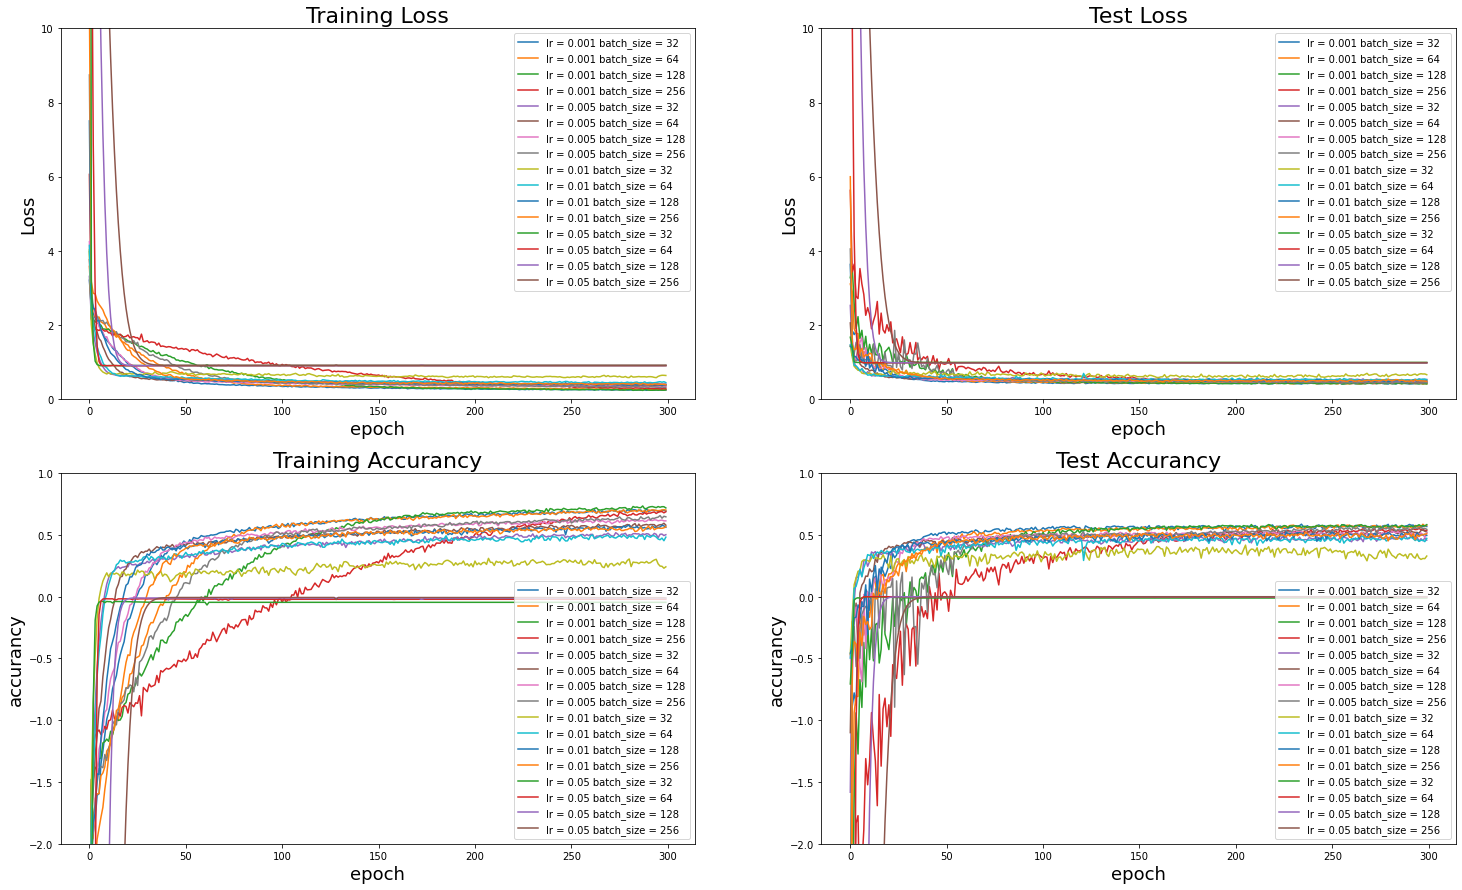

<Figure size 1800x1080 with 0 Axes>

In [56]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Training Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 10])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 10])

ax3.set_title("Training Accurancy", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test Accurancy", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

### 2 best models

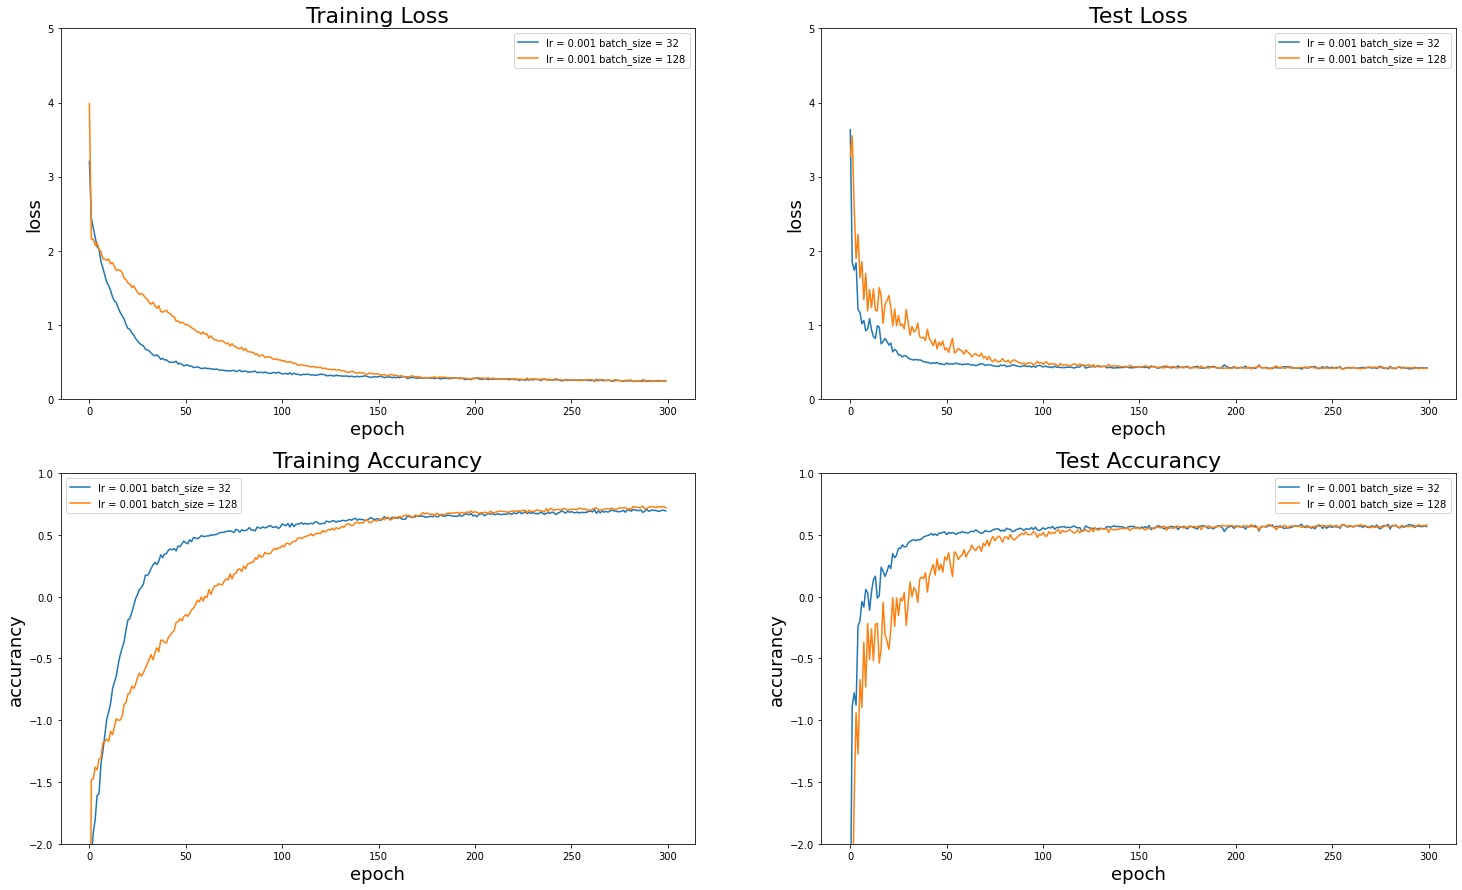

<Figure size 432x288 with 0 Axes>

In [73]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.001 batch_size = 32")
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 5])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.001 batch_size = 32")
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 5])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.001 batch_size = 32")
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.001 batch_size = 32")
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])
plt.show()

## 4.2. Training

In [61]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=2127, shuffle=False)

In [66]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), 'best_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 2.757583191072134, Accuracy: -2.5083027331596512
Test Avg. loss: 1.543282389640808, Accuracy: -0.7230044874384709
################## EPOCH 2 ##################
Train Avg. loss: 2.1227962912473464, Accuracy: -1.6740732193511068
Test Avg. loss: 1.0662685632705688, Accuracy: -0.1904402333913091
################## EPOCH 3 ##################
Train Avg. loss: 1.9860330495171081, Accuracy: -1.4769655769901167
Test Avg. loss: 1.4127156734466553, Accuracy: -0.5772326690137404
################## EPOCH 4 ##################
Train Avg. loss: 1.856533683556363, Accuracy: -1.3234828843741164
Test Avg. loss: 1.3356702327728271, Accuracy: -0.49121492455027704
################## EPOCH 5 ##################
Train Avg. loss: 1.7439949635724377, Accuracy: -1.2126755868048213
Test Avg. loss: 0.9676499366760254, Accuracy: -0.08033709486296381
################## EPOCH 6 ##################
Train Avg. loss: 1.6836804687080527, Accuracy: -1.1137581435

Train Avg. loss: 0.4595624260548362, Accuracy: 0.4405779269754465
Test Avg. loss: 0.43344464898109436, Accuracy: 0.5160788328259974
################## EPOCH 48 ##################
Train Avg. loss: 0.4395835441642238, Accuracy: 0.4563340608908898
Test Avg. loss: 0.424813449382782, Accuracy: 0.5257151741811397
################## EPOCH 49 ##################
Train Avg. loss: 0.44745077937841415, Accuracy: 0.4557580235482491
Test Avg. loss: 0.429411381483078, Accuracy: 0.5205817895130989
################## EPOCH 50 ##################
Train Avg. loss: 0.4529809054351391, Accuracy: 0.44747693861482885
Test Avg. loss: 0.4328014850616455, Accuracy: 0.5167968773371545
################## EPOCH 51 ##################
Train Avg. loss: 0.4290133653894851, Accuracy: 0.47302850349497494
Test Avg. loss: 0.42757850885391235, Accuracy: 0.5226280979390523
################## EPOCH 52 ##################
Train Avg. loss: 0.4350993865190592, Accuracy: 0.47047226101760875
Test Avg. loss: 0.41086846590042114, Acc

Train Avg. loss: 0.3516911192608059, Accuracy: 0.5706390784991765
Test Avg. loss: 0.3918195962905884, Accuracy: 0.5625512899366121
################## EPOCH 94 ##################
Train Avg. loss: 0.34112626454211714, Accuracy: 0.5880698341078897
Test Avg. loss: 0.3842076063156128, Accuracy: 0.5710497269359052
################## EPOCH 95 ##################
Train Avg. loss: 0.34635593826161293, Accuracy: 0.5803047269630078
Test Avg. loss: 0.38665515184402466, Accuracy: 0.568317172823981
################## EPOCH 96 ##################
Train Avg. loss: 0.35275366230118543, Accuracy: 0.5709568727116604
Test Avg. loss: 0.39455342292785645, Accuracy: 0.5594990804735238
################## EPOCH 97 ##################
Train Avg. loss: 0.3399954867878355, Accuracy: 0.5848537663167475
Test Avg. loss: 0.3915782570838928, Accuracy: 0.5628207191879104
################## EPOCH 98 ##################
Train Avg. loss: 0.3564282393825233, Accuracy: 0.5604028584296468
Test Avg. loss: 0.39502930641174316, Acc

Train Avg. loss: 0.3108677692655334, Accuracy: 0.6204876578586525
Test Avg. loss: 0.381777286529541, Accuracy: 0.5737630901851786
################## EPOCH 140 ##################
Train Avg. loss: 0.3088187517360189, Accuracy: 0.6218300263479114
Test Avg. loss: 0.37788650393486023, Accuracy: 0.5781069628150615
################## EPOCH 141 ##################
Train Avg. loss: 0.30157040768211946, Accuracy: 0.6282192543487034
Test Avg. loss: 0.37351563572883606, Accuracy: 0.5829867880675811
################## EPOCH 142 ##################
Train Avg. loss: 0.3128196367699849, Accuracy: 0.6210610572367995
Test Avg. loss: 0.3789002001285553, Accuracy: 0.5769752099078009
################## EPOCH 143 ##################
Train Avg. loss: 0.29912418057035683, Accuracy: 0.6362496350446373
Test Avg. loss: 0.3740108013153076, Accuracy: 0.5824339717327054
################## EPOCH 144 ##################
Train Avg. loss: 0.2943638559514867, Accuracy: 0.6393395641763691
Test Avg. loss: 0.3696577847003937, 

Train Avg. loss: 0.27939333332548466, Accuracy: 0.6596783289418559
Test Avg. loss: 0.3721528649330139, Accuracy: 0.5845082862320935
################## EPOCH 186 ##################
Train Avg. loss: 0.2758231155462283, Accuracy: 0.6614637238662842
Test Avg. loss: 0.3760668933391571, Accuracy: 0.5801384447109085
################## EPOCH 187 ##################
Train Avg. loss: 0.27694617421891454, Accuracy: 0.6579648732569567
Test Avg. loss: 0.36939382553100586, Accuracy: 0.5875886171400286
################## EPOCH 188 ##################
Train Avg. loss: 0.28092143687426596, Accuracy: 0.653885401612634
Test Avg. loss: 0.3718142807483673, Accuracy: 0.5848863369534298
################## EPOCH 189 ##################
Train Avg. loss: 0.2761610316154652, Accuracy: 0.6637200948952733
Test Avg. loss: 0.3821988105773926, Accuracy: 0.5732924663709287
################## EPOCH 190 ##################
Train Avg. loss: 0.2884466915874553, Accuracy: 0.6453030011190338
Test Avg. loss: 0.3732146918773651, 

Train Avg. loss: 0.26018452291425903, Accuracy: 0.6815166631374645
Test Avg. loss: 0.37701159715652466, Accuracy: 0.5790837301058849
################## EPOCH 232 ##################
Train Avg. loss: 0.25781134485190077, Accuracy: 0.6814382392455238
Test Avg. loss: 0.38241565227508545, Accuracy: 0.5730503926534934
################## EPOCH 233 ##################
Train Avg. loss: 0.26462576317047715, Accuracy: 0.6781567890770603
Test Avg. loss: 0.3739611506462097, Accuracy: 0.582489441378314
################## EPOCH 234 ##################
Train Avg. loss: 0.26765025911250506, Accuracy: 0.6688322434104357
Test Avg. loss: 0.38054561614990234, Accuracy: 0.5751381467797476
################## EPOCH 235 ##################
Train Avg. loss: 0.25945757965284183, Accuracy: 0.6808166276027016
Test Avg. loss: 0.37144792079925537, Accuracy: 0.5852953472491961
################## EPOCH 236 ##################
Train Avg. loss: 0.2640031085146549, Accuracy: 0.6744090160755534
Test Avg. loss: 0.3719624280929

Train Avg. loss: 0.24761012739929042, Accuracy: 0.6870108320444177
Test Avg. loss: 0.3701357841491699, Accuracy: 0.5867602501426545
################## EPOCH 278 ##################
Train Avg. loss: 0.254212096585591, Accuracy: 0.6869342854325589
Test Avg. loss: 0.39431625604629517, Accuracy: 0.5597638715680595
################## EPOCH 279 ##################
Train Avg. loss: 0.24842452848876329, Accuracy: 0.6982680460774988
Test Avg. loss: 0.376106858253479, Accuracy: 0.580093844273419
################## EPOCH 280 ##################
Train Avg. loss: 0.24435316821686306, Accuracy: 0.6958866408599111
Test Avg. loss: 0.3884199261665344, Accuracy: 0.566346887215931
################## EPOCH 281 ##################
Train Avg. loss: 0.24791262304424344, Accuracy: 0.6949168144089242
Test Avg. loss: 0.37898945808410645, Accuracy: 0.5768755185555905
################## EPOCH 282 ##################
Train Avg. loss: 0.25330181201373725, Accuracy: 0.6903539055214069
Test Avg. loss: 0.37642180919647217,

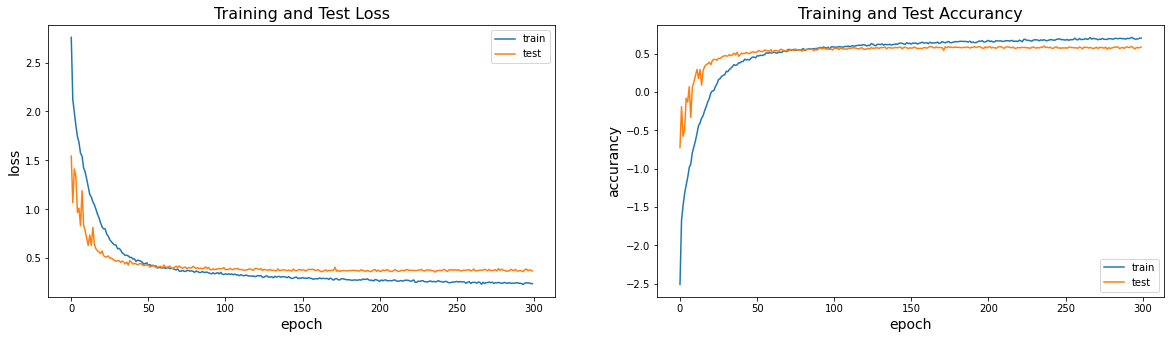

<Figure size 1440x360 with 0 Axes>

In [72]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Training and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.legend()
plt.show()

In [76]:
model = FCNN()
model.load_state_dict(torch.load('../../models/cardio_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.42140394
MSE: 0.35799992
RMSE: 0.598331
R2 Square 0.6003094018254558 

